# Run all Phylogenetic Independent Constrast analyses

## Overview
The purpose of this notebook is to run all Phylogenetic Independent Contrasts analyses for the comparison of coral disease, growth rate and microbiome composition

Descent with modification causes species to have correlated traits. Therefore, correlations between traits across species cannot safely be tested for using standard statistical methods, since the observations (species) are not independent of one another, which is an assumption of e.g. Pearson regression. 

We use two methods to address this: Phylogenetic Independent Contrasts (PICs) and Phylogenetic Generalized Least Squares regression (PGLS), both of which regress traits against one another while taking into account the structure of the tree. 

## Running this notebook

This notebook will run the PICs. It requires a tree and a trait table, in our case both at the genus level. 
The expected context for the notebook is that it is in a `core_analysis` folder, containing `input`,`output`, and `procedure` as subfolders. Thus, from this notebook the expected relative path to all data will be `../output/name_of_some_file.tsv`

The notebook also requires R to be installed, along with the ggplot2 and phytools packages.

# Import all required python libraries

We'll import all required python libraries now so there aren't surprises later.

In [69]:
from os.path import join,exists
from os import listdir
import subprocess
from pandas import DataFrame
import pandas as pd
from statsmodels.stats.multitest import fdrcorrection
from numpy import array

from IPython.display import display,Image

## Check for all required files

Before starting in earnest, we'll also check that all required files are present.

In [74]:

results_dir = join("..","output")
data_files = listdir(results_dir)

#List all files used in the analysis
trait_table_abundance_only = join(results_dir,"GCMP_trait_table_with_abundances_and_adiv_and_metadata.tsv")
trait_table = join(results_dir,"GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv")
trait_table_growth_data = join(results_dir,'GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data.tsv')
trait_table_australia = join(results_dir,'GCMP_trait_table_genus_australia_only.tsv')
trait_table_beta_diversity = join(results_dir,"GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv")

tree = join(results_dir,'huang_roy_genus_tree.newick')

#The PIC_results dir is a major output so define it now
pic_dir = join(results_dir,"PIC_results")


required_files = [trait_table,trait_table_growth_data,trait_table_australia,tree,trait_table_beta_diversity]

#Check that each required file is present
for required_file in required_files:
    
    if not exists(required_file):
        raise ValueError(f"Required file {required_file} is not in {results_dir}")
        
    print(f"File {required_file} ..... OK!")

File ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ..... OK!
File ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data.tsv ..... OK!
File ../output/GCMP_trait_table_genus_australia_only.tsv ..... OK!
File ../output/huang_roy_genus_tree.newick ..... OK!
File ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv ..... OK!


## Background on the phylomorphospace and pgls R scripts

For each hypothesis tested in the paper we run two custom R scripts: `phylomorpospace_r14.r` to generate phylomorphospace and phylogenetic independent contrasts (PIC) visualizations, and `pgls.r` to conduct model comparison of different branchlength transformations (lambda, delta, kappa, or no transformation) and then PGLS regression using the best fitting phylogenetic model.

The general interface for both script is as follows:

`Rscript phylomorphospace_r14.r {path_to_trait_table} {path_to_tree} {x_trait} {y_trait} {filter_column} {filter_value}`

- path_to_trait_table -- this is the path to a .tsv format trait table saying which species have which traits
- path_to_tree -- a path to a .newick format phylogeny for the species
- x_trait -- the x-axis trait for PIC analysis (independent variable)
- y_trait -- the y-axis trait for PIC analysis (response variable)
- filter_column -- if provided, a column in the trait table that will be used to filter results
- filter_value -- if provided, keep only data rows where the filter column has this value
- suffix -- if provided, add an extra suffix to the output folder (useful to distinguish special analyses)

Example:
`Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata.tsv ../output/huang_roy_genus_tree.newick   perc_dis dominance_tissue Weedy 0`

This example correlates disease prevalence (perc_dis) against microbiome dominance in tissue (dominance_tissue) for just corals whose functional group is not Weedy (filter column `Weedy`, filter_value `0`) using the standard GCMP trait table and phylogeny.

The script will generate output folders for each analysis with graphics, and statistical results, saved by default in subfolders of `../output/PIC_results` that are named based on the x and y trait values used, the filter column and the filter value. 

# Define  utility functions for running the R script and parsing output

To allow for a summary Supplementary Data file containing all results, we will parse the output and save key stats in a dataframe. Before beginning the actual analysis, we'll define two functions to a) run the phylomorphospace R script and b) parse the results

In [3]:
def phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,pic_filter_value,output_dir="../PIC_results/",verbose=True):
    """Run the phylomorphospace script"""
    #Build up the command we want to run
    pic_cmd = f"Rscript phylomorphospace_r14.r {pic_trait_table} {pic_tree} {pic_x_trait} {pic_y_trait} {pic_filter_column} {pic_filter_value} {output_dir} {pic_suffix}"
    print("Running PIC command:",pic_cmd)

    try:
        pic_output = subprocess.check_output(pic_cmd.split(),stderr=subprocess.STDOUT)
        pic_output = str(pic_output)
    except subprocess.CalledProcessError as exc:
        print(exc.output)
        return exc.output
    
    result_lines = pic_output.split("\\n")
    if verbose:    
        for line in result_lines:
            print(line)
            

    results = parse_pic_result_lines(result_lines)
    results['trait_table'] = pic_trait_table
    results['tree'] = tree
    results['pic_x_trait'] = pic_x_trait
    results['pic_y_trait'] = pic_y_trait
    results['pic_filter_column'] = pic_filter_column
    results['pic_filter_value'] = pic_filter_value
    results['pic_suffix'] = pic_suffix
    
    
    return results

def parse_pic_result_lines(lines):
    results = {}
    for line in lines:
        if line.startswith("pic.X"):
            fields = line.split()[1:]
            if len(fields)==4:
                slope,std_error,T,p =  fields
                sig_marker = 'n.s'
            else:
                slope,std_error,T,p,sig_marker = fields
                
            
            results['slope'] = slope
            results['slope_std_error'] = std_error
            results['T_stat'] = T
            results['p'] = p
            results['sig_marker'] = sig_marker
            
        if line.startswith('[1] \"Outputting results to: '):
            results['results_dir'] = line.split(":")[1].rstrip(",")
        if line.startswith("Multiple R-squared:"):
            R2 = float(line.split(":")[1].split(",")[0])
            results['R2'] = R2
            
    print("R2:",results['R2'])
    print("p:",p)
    return results


    
def add_FDR(df,p_value_column_name = "p",best_model_only = False):
    
    if best_model_only:
        #ignore high (worse) AICc models
        df = df.sort_values('best_model',ascending=False)
        df = df.reset_index(drop=True)
        best_models = df[df['best_model'] == True]
        p_values = list(best_models[p_value_column_name])
    else:
        p_values = list(df[p_value_column_name])
        
    p_values = array(list(map(float,[p.strip("<") if type(p) is str else p for p in p_values])))
    rejected,fdr_values = fdrcorrection(p_values,alpha=0.05,method='indep',is_sorted=False)  
    
    
    if best_model_only:
        df['FDR_q'] = 'NA (q values only calculated for best models by AIC)'
       
        for i,q in enumerate(fdr_values):
            df.loc[i,"FDR_q"] = q
        
    else:
        df['FDR_q'] = fdr_values
    return df
    

In [4]:
def pgls(trait_table,tree,x_trait,y_trait,filter_column,filter_value,output_dir="../PIC_results/",verbose=True):
    """Run the PGLS script"""

    #Build up the command we want to run
    pgls_cmd = f"Rscript pgls.r {trait_table} {tree} {x_trait} {y_trait} {filter_column} {filter_value} {output_dir}"
    print("Running PGLS script as follows:",pgls_cmd)

    try:
        pgls_output = subprocess.check_output(pgls_cmd.split(),stderr=subprocess.STDOUT)
        pgls_output = str(pgls_output)
    except subprocess.CalledProcessError as exc:
        print(exc.output)
        return exc.output
    
    result_lines = pgls_output.split("\\n")
    if verbose:    
        for line in result_lines:
            print(line)
            
    output_filepath = None
    for line in result_lines:
        if "Writing PGLS results file" in line:
            output_filepath = line.split(":")[1].rstrip('"')
            print("Output filepath:",output_filepath)
    if not output_filepath:
        raise ValueError("Can't find output filepath in results")
    
    results = parse_pgls_results(output_filepath)
    
    #Add compartment column
    #NOTE: the PGLS script is run once per compartment,
    #so at this stage we can safely assume that there
    #is only 1 compartment represented in the results
    compartments = ['all','mucus','tissue','skeleton']
    results['compartment'] = 'None'
    for possible_compartment in compartments:
        x_trait_values = results['x_trait']
        for i,x_trait_value in enumerate(x_trait_values):
            if x_trait_value.endswith(possible_compartment) or\
              x_trait_value.startswith(possible_compartment):
                results.loc[i,"compartment"] = possible_compartment
        
    #results = parse_pic_result_lines(result_lines)
    results['trait_table'] = trait_table
    results['tree'] = tree
    results['x_trait'] = x_trait
    results['y_trait'] = y_trait
    results['filter_column'] = filter_column
    results['filter_value'] = filter_value
    #results['pic_suffix'] = pic_suffix
    
    
    return results

def parse_pgls_results(pgls_results_filepath):
    df = pd.read_csv(pgls_results_filepath,sep="\t")
    df = add_delta_AICc(df)
    df['results_dir'] = pgls_results_filepath
    return df

def add_delta_AICc(df,aicc_column_name='AICc'):
    best_aic = min(df[aicc_column_name])
    df[f'delta_{aicc_column_name}'] = df[aicc_column_name] - best_aic
    return df


# Analysis 1. Compare multiple alpha diversity metrics against disease in each coral compartment 

In order to test whether microbiome structure correlated against disease susceptibility across coral genera, we regressed microbiome richness (`observed_features`), evenness (`gini_index`) and the Simpson index (`dominance`) against average aggregate long-term disease prevalence (`perc_dis`).

In [5]:
#Set output directory
analysis_label = "alpha_diversity_vs_disease"
analysis_output_dir = join(results_dir,"PIC_results",f"A1_{analysis_label}")

compartments = ["all","mucus","tissue","skeleton"]
metrics = ["observed_features","gini_index","dominance"]

# Make a dataframe to hold all the results
from pandas import DataFrame
pic_results_df = DataFrame({},columns = ["analysis_label","pic_x_trait","pic_y_trait","R2","p","sig_marker","FDR_q","slope","pic_filter_column","pic_filter_value","results_dir","slope_std_error","T_stat"])
pgls_results_df = DataFrame({},columns = ["analysis_label","x_trait","y_trait","R2","p","FDR_q","slope","model_name","best_model","AIC","AICc","delta_AICc","filter_column","filter_value","results_dir","x_trait_slope_95CI"])

for compartment in compartments:
    for metric in metrics:
        
        pic_trait_table = trait_table
        pic_tree = tree
        pic_x_trait = f'{metric}_{compartment}'
        pic_y_trait = 'perc_dis'
        pic_filter_column = 'None'
        pic_filter_value = 'None'
        pic_suffix = ''

        pic_result = phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
          pic_filter_value,analysis_output_dir,verbose = False)
        pic_result["analysis_label"] = analysis_label
        pic_results_df = pic_results_df.append(pic_result,ignore_index=True)   
        pic_results_df = add_FDR(pic_results_df)
       
        pgls_result = pgls(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
          pic_filter_value,analysis_output_dir,verbose = False)
        pgls_result["analysis_label"] = analysis_label
        pgls_results_df = pgls_results_df.append(pgls_result,ignore_index=True)
        pgls_results_df = add_FDR(pgls_results_df,best_model_only = True)

#Tidy up by adding whole-analysis information to the dataframes
pic_results_df["analysis_label"] = analysis_label
pgls_results_df["analysis_label"] = analysis_label
print("Done!")

Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick observed_features_all perc_dis None None ../output/PIC_results/A1_alpha_diversity_vs_disease 
R2: 0.0001051
p: 0.947
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick observed_features_all perc_dis None None ../output/PIC_results/A1_alpha_diversity_vs_disease
Output filepath: ../output/PIC_results/A1_alpha_diversity_vs_disease/PIC_observed_features_all_vs_perc_dis/PGLS_results.tsv
Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick gini_index_all perc_dis None None ../output/PIC_results/A1_alpha_diversity_vs_disease 
R2: 0.002423
p: 0.751
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait

KeyboardInterrupt: 

## Analysis 1 results

In [39]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")

,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,growth_rate_vs_disease,growth_rate_mm_per_year,perc_dis,0.175,0.0948,.,0.0948,20.75,None,None,../output/PIC_results/A11_growth_rate_vs_dise...,11.63,1.783,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,growth_rate_vs_disease,growth_rate_mm_per_year,perc_dis,0.120720,0.171792,0.171792,17.140912,BM_Lambda,True,98.562995,...,../output/PIC_results/A11_growth_rate_vs_disea...,-6.27004593131153 - 40.5518696393457,None,lambda=ML delta=1kappa=1,lambda,lambda : 0.962403487747834 (95% CI NA - NA ),3.836006,11.944366,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,growth_rate_vs_disease,growth_rate_mm_per_year,perc_dis,0.174953,0.094750,NA (q values only calculated for best models b...,20.750445,BM,False,100.554568,...,../output/PIC_results/A11_growth_rate_vs_disea...,-2.05383264970865 - 43.5547236014256,None,lambda=1 delta=1kappa=1,None,All parameters fixed,3.448515,11.634836,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,growth_rate_vs_disease,growth_rate_mm_per_year,perc_dis,0.146010,0.130125,NA (q values only calculated for best models b...,19.365625,BM_Kappa,False,100.216241,...,../output/PIC_results/A11_growth_rate_vs_disea...,-4.33594242192788 - 43.0671928754788,None,lambda=1 delta=1kappa=ML,kappa,kappa : 0.845841023407306 (95% CI 0.272155908...,3.742310,12.092637,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,growth_rate_vs_disease,growth_rate_mm_per_year,perc_dis,0.174953,0.094750,NA (q values only calculated for best models b...,20.750445,BM_Delta,False,100.554568,...,../output/PIC_results/A11_growth_rate_vs_disea...,-2.05383264970865 - 43.5547236014256,None,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.206877418293339 - NA ),3.448515,11.634836,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


# Analysis 2. Compare dominance against disease in Australia-only data

In [46]:
analysis_label = "alpha_diversity_vs_disease_australia_only"
analysis_output_dir = join(results_dir,"PIC_results",f"A2_{analysis_label}")

compartments = ["all","mucus","tissue","skeleton"]
metrics = ["dominance"]

# Make a dataframe to hold all the results
from pandas import DataFrame

pic_results_df = DataFrame({},columns = ["analysis_label","pic_x_trait","pic_y_trait","R2","p","sig_marker","FDR_q","slope","pic_filter_column","pic_filter_value","results_dir","slope_std_error","T_stat"])
pgls_results_df = DataFrame({},columns = ["analysis_label","x_trait","y_trait","R2","p","FDR_q","slope","model_name","best_model","AIC","AICc","delta_AICc","filter_column","filter_value","results_dir","x_trait_slope_95CI"])

for compartment in compartments:
    for metric in metrics:
        analysis_label = "alpha_diversity_vs_disease_australia_only"
        pic_trait_table = trait_table_australia
        pic_tree = tree
        pic_x_trait = f'{metric}_{compartment}'
        pic_y_trait = 'perc_dis'
        pic_filter_column = None
        pic_filter_value = None
        pic_suffix = ''

        pic_result = phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
          pic_filter_value,analysis_output_dir,verbose = False)
        pic_result["analysis_label"] = analysis_label
        pic_results_df = pic_results_df.append(pic_result,ignore_index=True)   
        pic_results_df = add_FDR(pic_results_df)
       
        pgls_result = pgls(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
          pic_filter_value,analysis_output_dir,verbose = False)
        pgls_result["analysis_label"] = analysis_label
        pgls_results_df = pgls_results_df.append(pgls_result,ignore_index=True)
        pgls_results_df = add_FDR(pgls_results_df,best_model_only = True)


print("Done!")

Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_genus_australia_only.tsv ../output/huang_roy_genus_tree.newick dominance_all perc_dis None None ../output/PIC_results/A2_alpha_diversity_vs_disease_australia_only 
R2: 0.3315
p: 0.00324
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_genus_australia_only.tsv ../output/huang_roy_genus_tree.newick dominance_all perc_dis None None ../output/PIC_results/A2_alpha_diversity_vs_disease_australia_only
Output filepath: ../output/PIC_results/A2_alpha_diversity_vs_disease_australia_only/PIC_dominance_all_vs_perc_dis/PGLS_results.tsv
Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_genus_australia_only.tsv ../output/huang_roy_genus_tree.newick dominance_mucus perc_dis None None ../output/PIC_results/A2_alpha_diversity_vs_disease_australia_only 
R2: 0.08331
p: 0.182
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_genus_australia_only.tsv ..

In [47]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")


,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,alpha_diversity_vs_disease_australia_only,dominance_all,perc_dis,0.33150,0.00324,**,0.006480,22.762,None,None,../output/PIC_results/A2_alpha_diversity_vs_d...,6.892,3.303,,../output/GCMP_trait_table_genus_australia_onl...,../output/huang_roy_genus_tree.newick
1,alpha_diversity_vs_disease_australia_only,dominance_mucus,perc_dis,0.08331,0.182,n.s,0.182000,13.212,None,None,../output/PIC_results/A2_alpha_diversity_vs_d...,9.563,1.382,,../output/GCMP_trait_table_genus_australia_onl...,../output/huang_roy_genus_tree.newick
2,alpha_diversity_vs_disease_australia_only,dominance_tissue,perc_dis,0.40580,0.000816,***,0.003264,10.904,None,None,../output/PIC_results/A2_alpha_diversity_vs_d...,2.813,3.876,,../output/GCMP_trait_table_genus_australia_onl...,../output/huang_roy_genus_tree.newick
3,alpha_diversity_vs_disease_australia_only,dominance_skeleton,perc_dis,0.10830,0.116,n.s,0.154667,16.288,None,None,../output/PIC_results/A2_alpha_diversity_vs_d...,9.967,1.634,,../output/GCMP_trait_table_genus_australia_onl...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,alpha_diversity_vs_disease_australia_only,dominance_all,perc_dis,0.406992,0.000797,0.001062,29.196315,BM_Lambda,True,139.515707,...,../output/PIC_results/A2_alpha_diversity_vs_di...,14.4694666423403 - 43.923164124569,all,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.5878803005131...,-0.809562,7.513698,../output/GCMP_trait_table_genus_australia_onl...,../output/huang_roy_genus_tree.newick
1,alpha_diversity_vs_disease_australia_only,dominance_mucus,perc_dis,0.443777,0.000520,0.00104,45.112361,BM_Lambda,True,133.335189,...,../output/PIC_results/A2_alpha_diversity_vs_di...,23.5108476773166 - 66.7138734020571,mucus,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.3958592838961...,-2.427818,11.021180,../output/GCMP_trait_table_genus_australia_onl...,../output/huang_roy_genus_tree.newick
2,alpha_diversity_vs_disease_australia_only,dominance_tissue,perc_dis,0.480112,0.000175,0.000699,14.060365,BM_Lambda,True,137.248495,...,../output/PIC_results/A2_alpha_diversity_vs_di...,7.94637328496198 - 20.1743558775802,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 0.0723257536864812 (95% CI NA - 0....,0.974054,3.119383,../output/GCMP_trait_table_genus_australia_onl...,../output/huang_roy_genus_tree.newick
3,alpha_diversity_vs_disease_australia_only,dominance_skeleton,perc_dis,0.105390,0.121680,0.12168,20.309734,BM_Lambda,True,149.384041,...,../output/PIC_results/A2_alpha_diversity_vs_di...,-4.41697240663058 - 45.036440024735,skeleton,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.5336000119691...,1.796949,12.615666,../output/GCMP_trait_table_genus_australia_onl...,../output/huang_roy_genus_tree.newick
4,alpha_diversity_vs_disease_australia_only,dominance_all,perc_dis,0.331479,0.003241,NA (q values only calculated for best models b...,22.761916,BM,False,152.228128,...,../output/PIC_results/A2_alpha_diversity_vs_di...,9.25416416746954 - 36.2696674133785,all,lambda=1 delta=1kappa=1,None,All parameters fixed,1.734197,6.891710,../output/GCMP_trait_table_genus_australia_onl...,../output/huang_roy_genus_tree.newick
5,alpha_diversity_vs_disease_australia_only,dominance_all,perc_dis,0.535875,0.000048,NA (q values only calculated for best models b...,30.498982,BM_Kappa,False,143.816753,...,../output/PIC_results/A2_alpha_diversity_vs_di...,18.6381346264221 - 42.3598297792873,all,lambda=1 delta=1kappa=ML,kappa,kappa : 1e-06 (95% CI NA - 0.543397184206051 ),0.497323,6.051453,../output/GCMP_trait_table_genus_australia_onl...,../output/huang_roy_genus_tree.newick
6,alpha_diversity_vs_disease_australia_only,dominance_all,perc_dis,0.331479,0.003241,NA (q values only calculated for best models b...,22.761916,BM_Delta,False,152.228128,...,../output/PIC_results/A2_alpha_diversity_vs_di...,9.25416416746954 - 36.2696674133785,all,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.30847377197554 - NA ),1.734197,6.891710,../output/GCMP_trait_table_genus_australia_onl...,../output/huang_roy_genus_tree.newick
7,alpha_diversity_vs_disease_australia_only,dominance_mucus,perc_dis,0.083312,0.181647,NA (q values only calculated for best models b...,13.211773,BM,False,153.977896,...,../output/PIC_results/A2_alpha_diversity_vs_di...,-5.53232432352316 - 31.955870039385,mucus,lambda=1 delta=1kappa=1,None,All parameters fixed,3.778893,9.563315,../output/GCMP_trait_table_genus_australia_onl...,../output/huang_roy_genus_tree.newick
8,alpha_diversity_vs_disease_australia_only,dominance_mucus,perc_dis,0.483939,0.000228,NA (q values only calculated for best models b...,41.906128,BM_Kappa,False,141.768133,...,../output/PIC_results/A2_alpha_diversity_vs_di...,23.3972959783598 - 60.4149595482101,mucus,lambda=1 delta=1kappa=ML,kappa,kappa : 1e-06 (95% CI NA - 0.311289106852145 ),-0.549554,9.443282,../output/GCMP_t

# Analysis 3. Compare Beta Diversity vs. Disease

NOTE: presently this includes only taxa that *also* have growth rate data. That restriction isn't necessary.


In [10]:

analysis_label = "beta_diversity_vs_disease"   
analysis_output_dir = join(results_dir,"PIC_results",f"A3_{analysis_label}")
print("Outputing results to directory:",analysis_output_dir)

pic_results_df = DataFrame({},columns = ["analysis_label","pic_x_trait","pic_y_trait","R2","p","sig_marker","FDR_q","slope","pic_filter_column","pic_filter_value","results_dir","slope_std_error","T_stat"])
pgls_results_df = DataFrame({},columns = ["analysis_label","x_trait","y_trait","R2","p","FDR_q","slope","model_name","best_model","AIC","AICc","delta_AICc","filter_column","filter_value","results_dir","x_trait_slope_95CI"])


for metric in ["unweighted_unifrac","weighted_unifrac"]:
    for PC_axis in [1,2,3]:
        for compartment in ["all","mucus","tissue","skeleton"]:
            
            pic_trait_table = trait_table_beta_diversity
            pic_tree = tree
            pic_x_trait = f"{compartment}_{metric}_ordination_PC{PC_axis}"
            print("PIC x trait:",pic_x_trait)
            pic_y_trait = 'perc_dis'
            
            pic_filter_column = 'None'
            pic_filter_value = 'None'
      
            pic_suffix = ''

            pic_result = phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
              pic_filter_value,analysis_output_dir,verbose = False)
            pic_result["analysis_label"] = analysis_label
            pic_results_df = pic_results_df.append(pic_result,ignore_index=True)   
            pic_results_df = add_FDR(pic_results_df)
       
            pgls_result = pgls(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
              pic_filter_value,analysis_output_dir,verbose = False)
            pgls_result["analysis_label"] = analysis_label
            pgls_results_df = pgls_results_df.append(pgls_result,ignore_index=True)
            pgls_results_df = add_FDR(pgls_results_df,best_model_only = True)
            


print("Done!")

Outputing results to directory: ../output/PIC_results/A3_beta_diversity_vs_disease
PIC x trait: all_unweighted_unifrac_ordination_PC1
Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv ../output/huang_roy_genus_tree.newick all_unweighted_unifrac_ordination_PC1 perc_dis None None ../output/PIC_results/A3_beta_diversity_vs_disease 
R2: 0.07612
p: 0.284
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv ../output/huang_roy_genus_tree.newick all_unweighted_unifrac_ordination_PC1 perc_dis None None ../output/PIC_results/A3_beta_diversity_vs_disease
Output filepath: ../output/PIC_results/A3_beta_diversity_vs_disease/PIC_all_unweighted_unifrac_ordination_PC1_vs_perc_dis/PGLS_results.tsv
PIC x trait: mucus_unweighted_unifrac_ordination_PC1
Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_tr

R2: 0.0356
p: 0.468
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv ../output/huang_roy_genus_tree.newick tissue_unweighted_unifrac_ordination_PC3 perc_dis None None ../output/PIC_results/A3_beta_diversity_vs_disease
Output filepath: ../output/PIC_results/A3_beta_diversity_vs_disease/PIC_tissue_unweighted_unifrac_ordination_PC3_vs_perc_dis/PGLS_results.tsv
PIC x trait: skeleton_unweighted_unifrac_ordination_PC3
Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv ../output/huang_roy_genus_tree.newick skeleton_unweighted_unifrac_ordination_PC3 perc_dis None None ../output/PIC_results/A3_beta_diversity_vs_disease 
R2: 0.0668
p: 0.317
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv ../output/huang_roy_genus_t

Output filepath: ../output/PIC_results/A3_beta_diversity_vs_disease/PIC_all_weighted_unifrac_ordination_PC3_vs_perc_dis/PGLS_results.tsv
PIC x trait: mucus_weighted_unifrac_ordination_PC3
Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv ../output/huang_roy_genus_tree.newick mucus_weighted_unifrac_ordination_PC3 perc_dis None None ../output/PIC_results/A3_beta_diversity_vs_disease 
R2: 0.07755
p: 0.296
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv ../output/huang_roy_genus_tree.newick mucus_weighted_unifrac_ordination_PC3 perc_dis None None ../output/PIC_results/A3_beta_diversity_vs_disease
Output filepath: ../output/PIC_results/A3_beta_diversity_vs_disease/PIC_mucus_weighted_unifrac_ordination_PC3_vs_perc_dis/PGLS_results.tsv
PIC x trait: tissue_weighted_unifrac_ordination_PC3
Running PIC comm

In [11]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")

,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,beta_diversity_vs_disease,all_unweighted_unifrac_ordination_PC1,perc_dis,0.076120,0.284,n.s,0.760800,-6.974,None,None,../output/PIC_results/A3_beta_diversity_vs_di...,6.273,-1.112,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,beta_diversity_vs_disease,mucus_unweighted_unifrac_ordination_PC1,perc_dis,0.004515,0.805,n.s,0.924571,-2.133,None,None,../output/PIC_results/A3_beta_diversity_vs_di...,8.464,-0.252,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,beta_diversity_vs_disease,tissue_unweighted_unifrac_ordination_PC1,perc_dis,0.007053,0.749,n.s,0.924571,-2.020,None,None,../output/PIC_results/A3_beta_diversity_vs_di...,6.188,-0.326,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,beta_diversity_vs_disease,skeleton_unweighted_unifrac_ordination_PC1,perc_dis,0.034740,0.474,n.s,0.808000,4.144,None,None,../output/PIC_results/A3_beta_diversity_vs_di...,5.640,0.735,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
4,beta_diversity_vs_disease,all_unweighted_unifrac_ordination_PC2,perc_dis,0.086820,0.251,n.s,0.760800,19.04,None,None,../output/PIC_results/A3_beta_diversity_vs_di...,15.94,1.194,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
5,beta_diversity_vs_disease,mucus_unweighted_unifrac_ordination_PC2,perc_dis,0.021830,0.585,n.s,0.808000,-4.645,None,None,../output/PIC_results/A3_beta_diversity_vs_di...,8.310,-0.559,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
6,beta_diversity_vs_disease,tissue_unweighted_unifrac_ordination_PC2,perc_dis,0.023260,0.559,n.s,0.808000,-6.049,None,None,../output/PIC_results/A3_beta_diversity_vs_di...,10.121,-0.598,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
7,beta_diversity_vs_disease,skeleton_unweighted_unifrac_ordination_PC2,perc_dis,0.134000,0.148,n.s,0.760800,-16.14,None,None,../output/PIC_results/A3_beta_diversity_vs_di...,10.60,-1.523,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
8,beta_diversity_vs_disease,all_unweighted_unifrac_ordination_PC3,perc_dis,0.112600,0.188,n.s,0.760800,-27.38,None,None,../output/PIC_results/A3_beta_diversity_vs_di...,19.84,-1.38,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
9,beta_diversity_vs_disease,mucus_unweighted_unifrac_ordination_PC3,perc_dis,0.047500,0.417,n.s,0.808000,6.325,None,None,../output/PIC_results/A3_beta_diversity_vs_di...,7.570,0.836,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,beta_diversity_vs_disease,all_unweighted_unifrac_ordination_PC1,perc_dis,0.014835,0.641441,0.987114,-3.054708,BM_Lambda,True,100.404555,...,../output/PIC_results/A3_beta_diversity_vs_dis...,-15.6522267118911 - 9.54281122358009,all,lambda=ML delta=1kappa=1,lambda,lambda : 0.952696745517665 (95% CI NA - NA ),6.009815,6.427306,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,beta_diversity_vs_disease,skeleton_weighted_unifrac_ordination_PC2,perc_dis,0.001606,0.878635,0.987268,-0.439454,BM_Lambda,True,100.606974,...,../output/PIC_results/A3_beta_diversity_vs_dis...,-5.98473507063217 - 5.10582750142506,skeleton,lambda=ML delta=1kappa=1,lambda,lambda : 0.944556369337437 (95% CI NA - NA ),5.996615,2.829225,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,beta_diversity_vs_disease,tissue_weighted_unifrac_ordination_PC2,perc_dis,0.116122,0.180742,0.987114,5.494742,BM_Lambda,True,99.869872,...,../output/PIC_results/A3_beta_diversity_vs_dis...,-2.17706122984475 - 13.1665450708973,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 0.0714298658785429 (95% CI NA - NA ),4.781294,3.914185,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,beta_diversity_vs_disease,skeleton_weighted_unifrac_ordination_PC3,perc_dis,0.044288,0.417515,0.987114,3.986617,BM_Lambda,True,99.867455,...,../output/PIC_results/A3_beta_diversity_vs_dis...,-5.38548772114143 - 13.3587219440157,skeleton,lambda=ML delta=1kappa=1,lambda,lambda : 0.946837317367716 (95% CI NA - NA ),6.192928,4.781686,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
4,beta_diversity_vs_disease,all_weighted_unifrac_ordination_PC2,perc_dis,0.000018,0.987268,0.987268,0.095345,BM_Lambda,True,100.633091,...,../output/PIC_results/A3_beta_diversity_vs_dis...,-11.4221425257212 - 11.6128331786249,all,lambda=ML delta=1kappa=1,lambda,lambda : 0.942314197757491 (95% CI NA - NA ),6.044576,5.876269,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,beta_diversity_vs_disease,mucus_unweighted_unifrac_ordination_PC2,perc_dis,0.021829,0.585023,NA (q values only calculated for best models b...,-4.644814,BM_Delta,False,91.763154,...,../output/PIC_results/A3_beta_diversity_vs_dis...,-20.9320380982388 - 11.6424103914259,mucus,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.158222219164655 - NA ),6.481570,8.309808,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
92,beta_diversity_vs_disease,mucus_weighted_unifrac_ordination_PC2,perc_dis,0.000911,0.911665,NA (q values only calculated for best models b...,-0.488124,BM_Kappa,False,92.101716,...,../output/PIC_results/A3_beta_diversity_vs_dis...,-8.95757303183193 - 7.98132460144487,mucus,lambda=1 delta=1kappa=ML,kappa,kappa : 1 (95% CI 0.296859968664675 - NA ),6.378266,4.321147,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
93,beta_diversity_vs_disease,mucus_weighted_unifrac_ordination_PC3,perc_dis,0.077546,0.296314,NA (q values only calculated for best models b...,-7.360372,BM_Delta,False,90.824803,...,../output/PIC_results/A3_beta_diversity_vs_dis...,-20.6582877528723 - 5.93754354912168,mucus,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.154497270138009 - NA ),6.241146,6.784651,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
94,beta_diversity_vs_disease,tissue_weighted_unifrac_ordination_PC3,perc_dis,0.028159,0.519726,NA (q values only calculated for best models b...,2.237346,BM,False,103.338360,...,../output/PIC_results/A3_beta_divers

# Analysis 4. Test dominance vs. disease in alpha vs. gamma proteobacteria dominated microbiomes

In [12]:
from pandas import DataFrame

analysis_label = "gamma_proteobacteria_dominance_vs_disease"   
analysis_output_dir = join(results_dir,"PIC_results",f"A4_{analysis_label}")

pic_results_df = DataFrame({},columns = ["analysis_label","pic_x_trait","pic_y_trait","R2","p","sig_marker","FDR_q","slope","pic_filter_column","pic_filter_value","results_dir","slope_std_error","T_stat"])
pgls_results_df = DataFrame({},columns = ["analysis_label","x_trait","y_trait","R2","p","FDR_q","slope","model_name","best_model","AIC","AICc","delta_AICc","filter_column","filter_value","results_dir","x_trait_slope_95CI"])


compartments = ["all","mucus","tissue","skeleton"]
metrics = ["dominance","observed_features","gini_index"]

for compartment in compartments:
    for metric in metrics:
        for microbial_taxon in ["D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria",\
                                "D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria"]:
            
            pic_trait_table = trait_table
            pic_tree = tree
            pic_x_trait = f'{metric}_{compartment}'
            pic_y_trait = 'perc_dis'
            
            pic_filter_column = f'most_abundant_class_{compartment}'
            pic_filter_value = microbial_taxon
      
            pic_suffix = ''

            pic_result = phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
              pic_filter_value,analysis_output_dir,verbose = False)
            pic_result["analysis_label"] = analysis_label
            pic_results_df = pic_results_df.append(pic_result,ignore_index=True)   
            pic_results_df = add_FDR(pic_results_df)
       
            pgls_result = pgls(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
              pic_filter_value,analysis_output_dir,verbose = False)
            pgls_result["analysis_label"] = analysis_label
            pgls_results_df = pgls_results_df.append(pgls_result,ignore_index=True)
            pgls_results_df = add_FDR(pgls_results_df,best_model_only = True)

print("Done!")

Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick dominance_all perc_dis most_abundant_class_all D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria ../output/PIC_results/A4_gamma_proteobacteria_dominance_vs_disease 
R2: 0.6683
p: 1.08e-06
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick dominance_all perc_dis most_abundant_class_all D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria ../output/PIC_results/A4_gamma_proteobacteria_dominance_vs_disease
Output filepath: ../output/PIC_results/A4_gamma_proteobacteria_dominance_vs_disease/PIC_dominance_all_vs_perc_dis_most_abundant_class_all_is_D_0__Bacteria_D_1__Proteobacteria_D_2__Gammaproteobacteria/PGLS_results.tsv
Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abun

R2: 0.09333
p: 0.391
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick observed_features_mucus perc_dis most_abundant_class_mucus D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria ../output/PIC_results/A4_gamma_proteobacteria_dominance_vs_disease
Output filepath: ../output/PIC_results/A4_gamma_proteobacteria_dominance_vs_disease/PIC_observed_features_mucus_vs_perc_dis_most_abundant_class_mucus_is_D_0__Bacteria_D_1__Proteobacteria_D_2__Alphaproteobacteria/PGLS_results.tsv
Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick gini_index_mucus perc_dis most_abundant_class_mucus D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria ../output/PIC_results/A4_gamma_proteobacteria_dominance_vs_disease 
R2: 0.06153
p: 0.186
Running PGLS script as follows: Rscript 

R2: 0.4089
p: 0.122
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick dominance_skeleton perc_dis most_abundant_class_skeleton D_0__Bacteria;D_1__Proteobacteria;D_2__Gammaproteobacteria ../output/PIC_results/A4_gamma_proteobacteria_dominance_vs_disease
Output filepath: ../output/PIC_results/A4_gamma_proteobacteria_dominance_vs_disease/PIC_dominance_skeleton_vs_perc_dis_most_abundant_class_skeleton_is_D_0__Bacteria_D_1__Proteobacteria_D_2__Gammaproteobacteria/PGLS_results.tsv
Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick dominance_skeleton perc_dis most_abundant_class_skeleton D_0__Bacteria;D_1__Proteobacteria;D_2__Alphaproteobacteria ../output/PIC_results/A4_gamma_proteobacteria_dominance_vs_disease 
R2: 0.08975
p: 0.199
Running PGLS script as follows: Rscript 

In [13]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")

,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,gamma_proteobacteria_dominance_vs_disease,dominance_all,perc_dis,0.668300,1.08e-06,***,0.000026,60.45,most_abundant_class_all,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,../output/PIC_results/A4_gamma_proteobacteria...,9.08,6.658,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,gamma_proteobacteria_dominance_vs_disease,dominance_all,perc_dis,0.147100,0.116,n.s,0.477600,4.912,most_abundant_class_all,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphapr...,../output/PIC_results/A4_gamma_proteobacteria...,2.957,1.661,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,gamma_proteobacteria_dominance_vs_disease,observed_features_all,perc_dis,0.033230,0.394,n.s,0.675429,0.02403,most_abundant_class_all,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,../output/PIC_results/A4_gamma_proteobacteria...,0.02763,0.87,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,gamma_proteobacteria_dominance_vs_disease,observed_features_all,perc_dis,0.212300,0.0543,.,0.434400,-0.015302,most_abundant_class_all,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphapr...,../output/PIC_results/A4_gamma_proteobacteria...,0.007368,-2.077,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
4,gamma_proteobacteria_dominance_vs_disease,gini_index_all,perc_dis,0.012100,0.609,n.s,0.913500,8.776,most_abundant_class_all,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,../output/PIC_results/A4_gamma_proteobacteria...,16.908,0.519,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
5,gamma_proteobacteria_dominance_vs_disease,gini_index_all,perc_dis,0.000487,0.931,n.s,0.962000,-0.4473,most_abundant_class_all,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphapr...,../output/PIC_results/A4_gamma_proteobacteria...,5.0648,-0.088,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
6,gamma_proteobacteria_dominance_vs_disease,dominance_mucus,perc_dis,0.004694,0.719,n.s,0.962000,1.438,most_abundant_class_mucus,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,../output/PIC_results/A4_gamma_proteobacteria...,3.956,0.363,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
7,gamma_proteobacteria_dominance_vs_disease,dominance_mucus,perc_dis,0.000299,0.962,n.s,0.962000,-0.7054,most_abundant_class_mucus,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphapr...,../output/PIC_results/A4_gamma_proteobacteria...,14.4148,-0.049,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
8,gamma_proteobacteria_dominance_vs_disease,observed_features_mucus,perc_dis,0.011680,0.57,n.s,0.912000,-0.004811,most_abundant_class_mucus,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,../output/PIC_results/A4_gamma_proteobacteria...,0.008362,-0.575,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
9,gamma_proteobacteria_dominance_vs_disease,observed_features_mucus,perc_dis,0.093330,0.391,n.s,0.675429,-0.02716,most_abundant_class_mucus,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphapr...,../output/PIC_results/A4_gamma_proteobacteria...,0.02993,-0.907,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,gamma_proteobacteria_dominance_vs_disease,dominance_all,perc_dis,0.499838,0.000112,0.002693,48.750675,BM_Lambda,True,136.864422,...,../output/PIC_results/A4_gamma_proteobacteria_...,28.3724541904814 - 69.1288948582862,all,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.4982781809766...,-3.504689,10.397051,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,gamma_proteobacteria_dominance_vs_disease,dominance_skeleton,perc_dis,0.035964,0.423246,0.823491,7.540859,BM_Lambda,True,119.498925,...,../output/PIC_results/A4_gamma_proteobacteria_...,-10.4956446068235 - 25.5773628360647,skeleton,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.9447680210136...,2.277943,9.202298,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,gamma_proteobacteria_dominance_vs_disease,observed_features_skeleton,perc_dis,0.247661,0.255761,0.767284,-0.004610,BM_Delta,True,24.451752,...,../output/PIC_results/A4_gamma_proteobacteria_...,-0.0116528079756221 - 0.00243286135783487,skeleton,lambda=1 delta=MLkappa=1,delta,delta : 0.654788600914862 (95% CI 0.033632807...,2.693191,0.003593,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,gamma_proteobacteria_dominance_vs_disease,gini_index_skeleton,perc_dis,0.140240,0.103791,0.431181,19.045157,BM_Lambda,True,117.209424,...,../output/PIC_results/A4_gamma_proteobacteria_...,-2.73982772493019 - 40.8301424256609,skeleton,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.6723474176529...,-13.746178,11.114788,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
4,gamma_proteobacteria_dominance_vs_disease,gini_index_mucus,perc_dis,0.093873,0.099615,0.431181,11.638357,BM_Lambda,True,165.682915,...,../output/PIC_results/A4_gamma_proteobacteria_...,-1.75508751121328 - 25.0318017795275,mucus,lambda=ML delta=1kappa=1,lambda,lambda : 0.0376433296925156 (95% CI NA - 0....,-7.117214,6.833390,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,gamma_proteobacteria_dominance_vs_disease,gini_index_all,perc_dis,0.000487,0.930720,NA (q values only calculated for best models b...,-0.447309,BM_Delta,False,100.015158,...,../output/PIC_results/A4_gamma_proteobacteria_...,-10.3742984939352 - 9.4796808373582,all,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.322802360104525 - NA ),2.743895,5.064791,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
92,gamma_proteobacteria_dominance_vs_disease,observed_features_skeleton,perc_dis,0.100238,0.173823,NA (q values only calculated for best models b...,-0.013343,BM_Delta,False,125.447890,...,../output/PIC_results/A4_gamma_proteobacteria_...,-0.0318105173276765 - 0.00512492185193524,skeleton,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.269381592948643 - NA ),6.865755,0.009422,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
93,gamma_proteobacteria_dominance_vs_disease,gini_index_skeleton,perc_dis,0.009985,0.831212,NA (q values only calculated for best models b...,-0.680861,BM,False,26.255619,...,../output/PIC_results/A4_gamma_proteobacteria_...,-6.62360079592142 - 5.26187901578728,skeleton,lambda=1 delta=1kappa=1,None,All parameters fixed,2.641894,3.032010,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
94,gamma_proteobacteria_dominance_vs_disease,gini_index_skeleton,perc_dis,0.009985,0.831212,NA (q values only calculated for best models b...,-0.680861,BM_Lambda,False,26.255619,...,../output/PIC_results/A4_gamma_proteobacteria_...,

In [13]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")

,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,gamma_proteobacteria_dominance_vs_disease,dominance_all,perc_dis,0.668300,1.08e-06,***,0.000026,60.45,most_abundant_class_all,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,../output/PIC_results/A4_gamma_proteobacteria...,9.08,6.658,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,gamma_proteobacteria_dominance_vs_disease,dominance_all,perc_dis,0.147100,0.116,n.s,0.477600,4.912,most_abundant_class_all,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphapr...,../output/PIC_results/A4_gamma_proteobacteria...,2.957,1.661,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,gamma_proteobacteria_dominance_vs_disease,observed_features_all,perc_dis,0.033230,0.394,n.s,0.675429,0.02403,most_abundant_class_all,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,../output/PIC_results/A4_gamma_proteobacteria...,0.02763,0.87,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,gamma_proteobacteria_dominance_vs_disease,observed_features_all,perc_dis,0.212300,0.0543,.,0.434400,-0.015302,most_abundant_class_all,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphapr...,../output/PIC_results/A4_gamma_proteobacteria...,0.007368,-2.077,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
4,gamma_proteobacteria_dominance_vs_disease,gini_index_all,perc_dis,0.012100,0.609,n.s,0.913500,8.776,most_abundant_class_all,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,../output/PIC_results/A4_gamma_proteobacteria...,16.908,0.519,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
5,gamma_proteobacteria_dominance_vs_disease,gini_index_all,perc_dis,0.000487,0.931,n.s,0.962000,-0.4473,most_abundant_class_all,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphapr...,../output/PIC_results/A4_gamma_proteobacteria...,5.0648,-0.088,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
6,gamma_proteobacteria_dominance_vs_disease,dominance_mucus,perc_dis,0.004694,0.719,n.s,0.962000,1.438,most_abundant_class_mucus,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,../output/PIC_results/A4_gamma_proteobacteria...,3.956,0.363,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
7,gamma_proteobacteria_dominance_vs_disease,dominance_mucus,perc_dis,0.000299,0.962,n.s,0.962000,-0.7054,most_abundant_class_mucus,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphapr...,../output/PIC_results/A4_gamma_proteobacteria...,14.4148,-0.049,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
8,gamma_proteobacteria_dominance_vs_disease,observed_features_mucus,perc_dis,0.011680,0.57,n.s,0.912000,-0.004811,most_abundant_class_mucus,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,../output/PIC_results/A4_gamma_proteobacteria...,0.008362,-0.575,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
9,gamma_proteobacteria_dominance_vs_disease,observed_features_mucus,perc_dis,0.093330,0.391,n.s,0.675429,-0.02716,most_abundant_class_mucus,D_0__Bacteria;D_1__Proteobacteria;D_2__Alphapr...,../output/PIC_results/A4_gamma_proteobacteria...,0.02993,-0.907,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,gamma_proteobacteria_dominance_vs_disease,dominance_all,perc_dis,0.499838,0.000112,0.002693,48.750675,BM_Lambda,True,136.864422,...,../output/PIC_results/A4_gamma_proteobacteria_...,28.3724541904814 - 69.1288948582862,all,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.4982781809766...,-3.504689,10.397051,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,gamma_proteobacteria_dominance_vs_disease,dominance_skeleton,perc_dis,0.035964,0.423246,0.823491,7.540859,BM_Lambda,True,119.498925,...,../output/PIC_results/A4_gamma_proteobacteria_...,-10.4956446068235 - 25.5773628360647,skeleton,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.9447680210136...,2.277943,9.202298,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,gamma_proteobacteria_dominance_vs_disease,observed_features_skeleton,perc_dis,0.247661,0.255761,0.767284,-0.004610,BM_Delta,True,24.451752,...,../output/PIC_results/A4_gamma_proteobacteria_...,-0.0116528079756221 - 0.00243286135783487,skeleton,lambda=1 delta=MLkappa=1,delta,delta : 0.654788600914862 (95% CI 0.033632807...,2.693191,0.003593,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,gamma_proteobacteria_dominance_vs_disease,gini_index_skeleton,perc_dis,0.140240,0.103791,0.431181,19.045157,BM_Lambda,True,117.209424,...,../output/PIC_results/A4_gamma_proteobacteria_...,-2.73982772493019 - 40.8301424256609,skeleton,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.6723474176529...,-13.746178,11.114788,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
4,gamma_proteobacteria_dominance_vs_disease,gini_index_mucus,perc_dis,0.093873,0.099615,0.431181,11.638357,BM_Lambda,True,165.682915,...,../output/PIC_results/A4_gamma_proteobacteria_...,-1.75508751121328 - 25.0318017795275,mucus,lambda=ML delta=1kappa=1,lambda,lambda : 0.0376433296925156 (95% CI NA - 0....,-7.117214,6.833390,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,gamma_proteobacteria_dominance_vs_disease,gini_index_all,perc_dis,0.000487,0.930720,NA (q values only calculated for best models b...,-0.447309,BM_Delta,False,100.015158,...,../output/PIC_results/A4_gamma_proteobacteria_...,-10.3742984939352 - 9.4796808373582,all,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.322802360104525 - NA ),2.743895,5.064791,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
92,gamma_proteobacteria_dominance_vs_disease,observed_features_skeleton,perc_dis,0.100238,0.173823,NA (q values only calculated for best models b...,-0.013343,BM_Delta,False,125.447890,...,../output/PIC_results/A4_gamma_proteobacteria_...,-0.0318105173276765 - 0.00512492185193524,skeleton,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.269381592948643 - NA ),6.865755,0.009422,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
93,gamma_proteobacteria_dominance_vs_disease,gini_index_skeleton,perc_dis,0.009985,0.831212,NA (q values only calculated for best models b...,-0.680861,BM,False,26.255619,...,../output/PIC_results/A4_gamma_proteobacteria_...,-6.62360079592142 - 5.26187901578728,skeleton,lambda=1 delta=1kappa=1,None,All parameters fixed,2.641894,3.032010,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
94,gamma_proteobacteria_dominance_vs_disease,gini_index_skeleton,perc_dis,0.009985,0.831212,NA (q values only calculated for best models b...,-0.680861,BM_Lambda,False,26.255619,...,../output/PIC_results/A4_gamma_proteobacteria_...,

# Analysis 5. Test Endozoicomonas vs. dominance in tissue microbiomes

In [14]:

metrics = ["dominance_tissue","observed_features_tissue","gini_index_tissue","perc_dis"]
analysis_label = "Endozoicomonas_vs_dominance_and_disease"   
analysis_output_dir = join(results_dir,"PIC_results",f"A5_{analysis_label}")
# Make a dataframe to hold all the results
from pandas import DataFrame

pic_results_df = DataFrame({},columns = ["analysis_label","pic_x_trait","pic_y_trait","R2","p","sig_marker","FDR_q","slope","pic_filter_column","pic_filter_value","results_dir","slope_std_error","T_stat"])
pgls_results_df = DataFrame({},columns = ["analysis_label","x_trait","y_trait","R2","p","FDR_q","slope","model_name","best_model","AIC","AICc","delta_AICc","filter_column","filter_value","results_dir","x_trait_slope_95CI"])


for metric in metrics:
    pic_trait_table = trait_table
    pic_tree = tree
    pic_x_trait = 'tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas'
    pic_y_trait = metric
    pic_filter_column = 'None'
    pic_filter_value = 'None'
    pic_suffix = ''

    pic_result = phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
    pic_filter_value,analysis_output_dir,verbose = False)
    pic_result["analysis_label"] = analysis_label
    pic_results_df = pic_results_df.append(pic_result,ignore_index=True)   
    pic_results_df = add_FDR(pic_results_df)
       
    pgls_result = pgls(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
      pic_filter_value,analysis_output_dir,verbose = False)
    pgls_result["analysis_label"] = analysis_label
    pgls_results_df = pgls_results_df.append(pgls_result,ignore_index=True)
    pgls_results_df = add_FDR(pgls_results_df,best_model_only = True)



print("Done!")

Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas dominance_tissue None None ../output/PIC_results/A5_Endozoicomonas_vs_dominance_and_disease 
R2: 0.5177
p: 2.56e-08
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas dominance_tissue None None ../output/PIC_results/A5_Endozoicomonas_vs_dominance_and_disease
Output filepath: ../output/PIC_results/A5_Endozoicomonas_vs_dominance_and_disease/PIC_tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillale

In [15]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")

,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,Endozoicomonas_vs_dominance_and_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,dominance_tissue,0.517700,2.56e-08,***,1.024000e-07,6.300e-04,None,None,../output/PIC_results/A5_Endozoicomonas_vs_do...,9.274e-05,6.794,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,Endozoicomonas_vs_dominance_and_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,observed_features_tissue,0.006276,0.605,n.s,8.066667e-01,-0.04392,None,None,../output/PIC_results/A5_Endozoicomonas_vs_do...,0.08428,-0.521,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,Endozoicomonas_vs_dominance_and_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,gini_index_tissue,0.000386,0.898,n.s,8.980000e-01,-2.104e-05,None,None,../output/PIC_results/A5_Endozoicomonas_vs_do...,1.633e-04,-0.129,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,Endozoicomonas_vs_dominance_and_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.241500,0.00128,**,2.560000e-03,0.011994,None,None,../output/PIC_results/A5_Endozoicomonas_vs_do...,0.003448,3.479,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,Endozoicomonas_vs_dominance_and_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,dominance_tissue,0.593225,6.177392e-10,0.0,0.000670,BM_Lambda,True,-87.678878,...,../output/PIC_results/A5_Endozoicomonas_vs_dom...,0.000504105394107334 - 0.000835724281959083,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.5886635517390...,0.104381,0.000085,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,Endozoicomonas_vs_dominance_and_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,observed_features_tissue,0.017312,3.889415e-01,0.388941,-0.079867,BM_Lambda,True,542.186157,...,../output/PIC_results/A5_Endozoicomonas_vs_dom...,-0.259724868723162 - 0.099990731445362,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 0.0357961118923065 (95% CI NA - 0....,175.393283,0.091764,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,Endozoicomonas_vs_dominance_and_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,gini_index_tissue,0.040052,1.874659e-01,0.249955,0.000133,BM_Lambda,True,-73.097741,...,../output/PIC_results/A5_Endozoicomonas_vs_dom...,-6.17307225621437e-05 - 0.000328211671268493,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.5337654615585...,0.861697,0.000099,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,Endozoicomonas_vs_dominance_and_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.301960,2.402179e-04,0.00048,0.015039,BM_Lambda,True,223.568869,...,../output/PIC_results/A5_Endozoicomonas_vs_dom...,0.00776882626930944 - 0.0223094227323264,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.2712559878484...,1.780062,0.003709,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
4,Endozoicomonas_vs_dominance_and_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,dominance_tissue,0.517680,2.563118e-08,NA (q values only calculated for best models b...,0.000630,BM,False,-50.155417,...,../output/PIC_results/A5_Endozoicomonas_vs_dom...,0.000448276744717259 - 0.000811827562996169,tissue,lambda=1 delta=1kappa=1,None,All parameters fixed,0.125446,0.000093,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
5,Endozoicomonas_vs_dominance_and_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,dominance_tissue,0.609635,2.516467e-10,NA (q values only calculated for best models b...,0.000649,BM_Kappa,False,-72.966385,...,../output/PIC_results/A5_Endozoicomonas_vs_dom...,0.000493596567592817 - 0.00080393959513008,tissue,lambda=1 delta=1kappa=ML,kappa,kappa : 0.225348315903438 (95% CI NA - 0.53...,0.151384,0.000079,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
6,Endozoicomonas_vs_dominance_and_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,dominance_tissue,0.517680,2.563118e-08,NA (q values only calculated for best models b...,0.000630,BM_Delta,False,-50.155417,...,../output/PIC_results/A5_Endozoicomonas_vs_dom...,0.000448276744717259 - 0.000811827562996169,tissue,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.435538885291692 - NA ),0.125446,0.000093,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
7,Endozoicomonas_vs_dominance_and_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,observed_features_tissue,0.006276,6.049402e-01,NA (q values only calculated for best models b...,-0.043922,BM,False,562.930334,...,../output/PIC_results/A5_Endozoicomonas_vs_dom...,-0.209109027476679 - 0.121265754328193,tissue,lambda=1 delta=1kappa=1,None,All parameters fixed,170.949459,0.084279,../output/GCMP_trait_table_with_abundances_and...,

# Analysis 6. Test for correlations between pathogen abundance in healthy corals and disease susceptibility

In [16]:
from pandas import DataFrame


analysis_label = "opportunists_vs_disease"   
analysis_output_dir = join(results_dir,"PIC_results",f"A6_{analysis_label}")

pic_results_df = DataFrame({},columns = ["analysis_label","pic_x_trait","pic_y_trait","R2","p","sig_marker","FDR_q","slope","pic_filter_column","pic_filter_value","results_dir","slope_std_error","T_stat"])
pgls_results_df = DataFrame({},columns = ["analysis_label","x_trait","y_trait","R2","p","FDR_q","slope","model_name","best_model","AIC","AICc","delta_AICc","filter_column","filter_value","results_dir","x_trait_slope_95CI"])


compartments = ["tissue"]
metrics = ["perc_disease","dominance","observed_features","gini_index"]
putative_pathogens =\
  ["D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Vibrionales",
   "D_0__Bacteria___D_1__Cyanobacteria___D_2__Oxyphotobacteria___D_3__Nostocales",
   "D_0__Bacteria___D_1__Proteobacteria___D_2__Alphaproteobacteria___D_3__Rickettsiales___D_4__Midichloriaceae___D_5__MD3_55"]

for compartment in compartments:
    for metric in metrics:
        for microbial_taxon in putative_pathogens:
            
            pic_trait_table = trait_table
            pic_tree = tree
            pic_x_trait = f'{compartment}_{microbial_taxon}'
            pic_y_trait = 'perc_dis'
            
            pic_filter_column = 'None'
            pic_filter_value = 'None'
      
            pic_suffix = ''

            pic_result = phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
             pic_filter_value,analysis_output_dir,verbose = False)
            pic_result["analysis_label"] = analysis_label
            pic_results_df = pic_results_df.append(pic_result,ignore_index=True)   
            pic_results_df = add_FDR(pic_results_df)

            pgls_result = pgls(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
              pic_filter_value,analysis_output_dir,verbose = False)
            pgls_result["analysis_label"] = analysis_label
            pgls_results_df = pgls_results_df.append(pgls_result,ignore_index=True)
            pgls_results_df = add_FDR(pgls_results_df,best_model_only = True)
            
            


print("Done!")

Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Vibrionales perc_dis None None ../output/PIC_results/A6_opportunists_vs_disease 
R2: 0.003987
p: 0.699
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Vibrionales perc_dis None None ../output/PIC_results/A6_opportunists_vs_disease
Output filepath: ../output/PIC_results/A6_opportunists_vs_disease/PIC_tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Vibrionales_vs_perc_dis/PGLS_results.tsv
Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_gen

R2: 0.003987
p: 0.699
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Vibrionales perc_dis None None ../output/PIC_results/A6_opportunists_vs_disease
Output filepath: ../output/PIC_results/A6_opportunists_vs_disease/PIC_tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Vibrionales_vs_perc_dis/PGLS_results.tsv
Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Cyanobacteria___D_2__Oxyphotobacteria___D_3__Nostocales perc_dis None None ../output/PIC_results/A6_opportunists_vs_disease 
R2: 0.007824
p: 0.587
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/h

In [17]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")

,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.003987,0.699,n.s,0.842,-0.01385,None,None,../output/PIC_results/A6_opportunists_vs_dise...,0.03552,-0.39,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Cyanobacteria___D_...,perc_dis,0.007824,0.587,n.s,0.842,0.01792,None,None,../output/PIC_results/A6_opportunists_vs_dise...,0.03274,0.547,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.001065,0.842,n.s,0.842,-0.002881,None,None,../output/PIC_results/A6_opportunists_vs_dise...,0.014316,-0.201,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.003987,0.699,n.s,0.842,-0.01385,None,None,../output/PIC_results/A6_opportunists_vs_dise...,0.03552,-0.39,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
4,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Cyanobacteria___D_...,perc_dis,0.007824,0.587,n.s,0.842,0.01792,None,None,../output/PIC_results/A6_opportunists_vs_dise...,0.03274,0.547,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
5,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.001065,0.842,n.s,0.842,-0.002881,None,None,../output/PIC_results/A6_opportunists_vs_dise...,0.014316,-0.201,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
6,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.003987,0.699,n.s,0.842,-0.01385,None,None,../output/PIC_results/A6_opportunists_vs_dise...,0.03552,-0.39,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
7,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Cyanobacteria___D_...,perc_dis,0.007824,0.587,n.s,0.842,0.01792,None,None,../output/PIC_results/A6_opportunists_vs_dise...,0.03274,0.547,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
8,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.001065,0.842,n.s,0.842,-0.002881,None,None,../output/PIC_results/A6_opportunists_vs_dise...,0.014316,-0.201,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
9,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.003987,0.699,n.s,0.842,-0.01385,None,None,../output/PIC_results/A6_opportunists_vs_dise...,0.03552,-0.39,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.004591,0.677818,0.803879,-0.021420,BM_Lambda,True,237.763946,...,../output/PIC_results/A6_opportunists_vs_disea...,-0.121700692503155 - 0.078860063222263,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.2523091962942...,3.410746,0.051163,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Cyanobacteria___D_...,perc_dis,0.001683,0.801560,0.803879,-0.009338,BM_Lambda,True,237.880656,...,../output/PIC_results/A6_opportunists_vs_disea...,-0.0816490364493445 - 0.0629739885632129,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.2359467061268...,3.362504,0.036894,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.001643,0.803879,0.803879,-0.001882,BM_Lambda,True,237.882254,...,../output/PIC_results/A6_opportunists_vs_disea...,-0.0166318035185942 - 0.0128680033711736,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.2425459279260...,3.278003,0.007525,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.001643,0.803879,0.803879,-0.001882,BM_Lambda,True,237.882254,...,../output/PIC_results/A6_opportunists_vs_disea...,-0.0166318035185942 - 0.0128680033711736,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.2425459279260...,3.278003,0.007525,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
4,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.004591,0.677818,0.803879,-0.021420,BM_Lambda,True,237.763946,...,../output/PIC_results/A6_opportunists_vs_disea...,-0.121700692503155 - 0.078860063222263,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.2523091962942...,3.410746,0.051163,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
5,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Cyanobacteria___D_...,perc_dis,0.001683,0.801560,0.803879,-0.009338,BM_Lambda,True,237.880656,...,../output/PIC_results/A6_opportunists_vs_disea...,-0.0816490364493445 - 0.0629739885632129,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.2359467061268...,3.362504,0.036894,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
6,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.004591,0.677818,0.803879,-0.021420,BM_Lambda,True,237.763946,...,../output/PIC_results/A6_opportunists_vs_disea...,-0.121700692503155 - 0.078860063222263,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.2523091962942...,3.410746,0.051163,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
7,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.004591,0.677818,0.803879,-0.021420,BM_Lambda,True,237.763946,...,../output/PIC_results/A6_opportunists_vs_disea...,-0.121700692503155 - 0.078860063222263,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.2523091962942...,3.410746,0.051163,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
8,opportunists_vs_disease,tissue_D_0__Bacteria___D_1__Cyanobacteria___D_...,perc_dis,0.001683,0.801560,0.803879,-0.009338,BM_Lambda,True,237.880656,...,../output/PIC_results/A6_opportunists_vs_disea...,-0.0816490364493445 - 0.0629739885632129,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-

# Analysis 7. Test  *Endozoicomonas* abundance by life history strategy

In [18]:
from pandas import DataFrame

pic_results_df = DataFrame({},columns = ["analysis_label","pic_x_trait","pic_y_trait","R2","p","sig_marker","FDR_q","slope","pic_filter_column","pic_filter_value","results_dir","slope_std_error","T_stat"])
pgls_results_df = DataFrame({},columns = ["analysis_label","x_trait","y_trait","R2","p","FDR_q","slope","model_name","best_model","AIC","AICc","delta_AICc","filter_column","filter_value","results_dir","x_trait_slope_95CI"])

analysis_label = "Life_history_strategy_vs_Endozoicomonas"
analysis_output_dir = join(results_dir,"PIC_results",f"A7_{analysis_label}")

compartments = ["tissue"]
life_history_strategy = ["Weedy","Stress_tolerant","Generalist"]

for compartment in compartments:
    for strategy in life_history_strategy:
            
            
            pic_trait_table = trait_table
            pic_tree = tree
            pic_x_trait = strategy
            pic_y_trait = f'{compartment}_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas'
            
            
            pic_filter_column = 'None'
            pic_filter_value = 'None'
      
            pic_suffix = ''

            pic_result = phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
             pic_filter_value,analysis_output_dir,verbose = False)
            pic_result["analysis_label"] = analysis_label
            pic_results_df = pic_results_df.append(pic_result,ignore_index=True)   
            pic_results_df = add_FDR(pic_results_df)

            pgls_result = pgls(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
              pic_filter_value,analysis_output_dir,verbose = False)
            pgls_result["analysis_label"] = analysis_label
            pgls_results_df = pgls_results_df.append(pgls_result,ignore_index=True)
            pgls_results_df = add_FDR(pgls_results_df,best_model_only = True)


print("Done!")

Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick Weedy tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas None None ../output/PIC_results/A7_Life_history_strategy_vs_Endozoicomonas 
R2: 0.9452
p: <2e-16
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick Weedy tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas None None ../output/PIC_results/A7_Life_history_strategy_vs_Endozoicomonas
Output filepath: ../output/PIC_results/A7_Life_history_strategy_vs_Endozoicomonas/PIC_Weedy_vs_tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozo

In [19]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")

,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,Life_history_strategy_vs_Endozoicomonas,Weedy,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,0.94520,<2e-16,***,6.000000e-16,278.47,None,None,../output/PIC_results/A7_Life_history_strateg...,10.23,27.23,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,Life_history_strategy_vs_Endozoicomonas,Stress_tolerant,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,0.04187,0.178,n.s,1.780000e-01,-51.59,None,None,../output/PIC_results/A7_Life_history_strateg...,37.63,-1.371,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,Life_history_strategy_vs_Endozoicomonas,Generalist,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,0.11330,0.0238,*,3.570000e-02,98.78,None,None,../output/PIC_results/A7_Life_history_strateg...,42.15,2.344,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,Life_history_strategy_vs_Endozoicomonas,Weedy,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,0.169452,0.004963,0.014888,227.820947,BM_Lambda,True,578.697403,...,../output/PIC_results/A7_Life_history_strategy...,77.0650544803659 - 378.576839944171,None,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.1805651967491...,68.675138,76.916272,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,Life_history_strategy_vs_Endozoicomonas,Stress_tolerant,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,0.006497,0.598639,0.787793,-26.184985,BM_Lambda,True,586.759213,...,../output/PIC_results/A7_Life_history_strategy...,-122.96711455243 - 70.5971453585372,None,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.2617021737789...,98.817989,49.378638,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,Life_history_strategy_vs_Endozoicomonas,Generalist,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,0.001703,0.787793,0.787793,22.840920,BM_Lambda,True,586.975828,...,../output/PIC_results/A7_Life_history_strategy...,-142.439586287821 - 188.12142549515,None,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.2612326883492...,86.895615,84.326789,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,Life_history_strategy_vs_Endozoicomonas,Weedy,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,0.033879,0.226143,NA (q values only calculated for best models b...,278.469385,BM,False,614.751088,...,../output/PIC_results/A7_Life_history_strategy...,-166.009200317268 - 722.947969455577,None,lambda=1 delta=1kappa=1,None,All parameters fixed,43.577602,226.774788,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
4,Life_history_strategy_vs_Endozoicomonas,Weedy,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,0.096429,0.037883,NA (q values only calculated for best models b...,273.117859,BM_Kappa,False,603.439727,...,../output/PIC_results/A7_Life_history_strategy...,23.2281071919854 - 523.007610066557,None,lambda=1 delta=1kappa=ML,kappa,kappa : 0.0183895435011849 (95% CI NA - 0.5...,19.426294,127.494771,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
5,Life_history_strategy_vs_Endozoicomonas,Weedy,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,0.033879,0.226143,NA (q values only calculated for best models b...,278.469385,BM_Delta,False,614.751088,...,../output/PIC_results/A7_Life_history_strategy...,-166.009200317268 - 722.947969455577,None,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.432901165069079 - NA ),43.577602,226.774788,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
6,Life_history_strategy_vs_Endozoicomonas,Stress_tolerant,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,0.011294,0.487169,NA (q values only calculated for best models b...,-51.589293,BM,False,615.790930,...,../output/PIC_results/A7_Life_history_strategy...,-195.863232635832 - 92.68464746259,None,lambda=1 delta=1kappa=1,None,All parameters fixed,113.093936,73.609153,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
7,Life_history_strategy_vs_Endozoicomonas,Stress_tolerant,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,0.008318,0.551295,NA (q values only calculated for best models b...,-43.870678,BM_Kappa,False,607.318662,...,../output/PIC_results/A7_Life_history_strategy...,-187.051337684814 - 99.3099817849873,None,lambda=1 delta=1kappa=ML,kappa,kappa : 0.182955324078069 (95% CI NA - 0.73...,120.357985,73.051357,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
8,Life_history_strategy_vs_Endozoicomonas,Str

# Analysis 8. Test  *Endozoicomonas* vs. disease correlation within Stress-tolerant corals

In [20]:
from pandas import DataFrame

pic_results_df = DataFrame({},columns = ["analysis_label","pic_x_trait","pic_y_trait","R2","p","sig_marker","FDR_q","slope","pic_filter_column","pic_filter_value","results_dir","slope_std_error","T_stat"])
pgls_results_df = DataFrame({},columns = ["analysis_label","x_trait","y_trait","R2","p","FDR_q","slope","model_name","best_model","AIC","AICc","delta_AICc","filter_column","filter_value","results_dir","x_trait_slope_95CI"])

analysis_label = "Endozoicomonas_vs_disease_in_stress_tolerant_corals"
analysis_output_dir = join(results_dir,"PIC_results",f"A8_{analysis_label}")

compartments = ["tissue"]
life_history_strategy = ['Stress_tolerant']


for compartment in compartments:
    for strategy in life_history_strategy:
            
            
            pic_trait_table = trait_table
            pic_tree = tree
            
            pic_x_trait = f'{compartment}_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas'
            pic_y_trait = 'perc_dis'
            
            pic_filter_column = strategy
            pic_filter_value = '1'
      
            pic_suffix = ''

            pic_result = phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
             pic_filter_value,analysis_output_dir,verbose = False)
            pic_result["analysis_label"] = analysis_label
            pic_results_df = pic_results_df.append(pic_result,ignore_index=True)   
            pic_results_df = add_FDR(pic_results_df)

            pgls_result = pgls(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
              pic_filter_value,analysis_output_dir,verbose = False)
            pgls_result["analysis_label"] = analysis_label
            pgls_results_df = pgls_results_df.append(pgls_result,ignore_index=True)
            pgls_results_df = add_FDR(pgls_results_df,best_model_only = True)

print("Done!")

Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas perc_dis Stress_tolerant 1 ../output/PIC_results/A8_Endozoicomonas_vs_disease_in_stress_tolerant_corals 
R2: 0.5995
p: 0.000264
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas perc_dis Stress_tolerant 1 ../output/PIC_results/A8_Endozoicomonas_vs_disease_in_stress_tolerant_corals
Output filepath: ../output/PIC_results/A8_Endozoicomonas_vs_disease_in_stress_tolerant_corals/PIC_tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammapr

In [21]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")

,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,Endozoicomonas_vs_disease_in_stress_tolerant_c...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.5995,0.000264,***,0.000264,0.021018,Stress_tolerant,1,../output/PIC_results/A8_Endozoicomonas_vs_di...,0.004435,4.739,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,Endozoicomonas_vs_disease_in_stress_tolerant_c...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.815067,7.047565e-07,0.000001,0.029914,BM_Lambda,True,77.534588,...,../output/PIC_results/A8_Endozoicomonas_vs_dis...,0.0227027010812898 - 0.0371245167305107,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.5538792140516...,0.690941,0.003679,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,Endozoicomonas_vs_disease_in_stress_tolerant_c...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.599528,2.637935e-04,NA (q values only calculated for best models b...,0.021018,BM,False,99.497466,...,../output/PIC_results/A8_Endozoicomonas_vs_dis...,0.0123248105783789 - 0.0297114913440805,tissue,lambda=1 delta=1kappa=1,None,All parameters fixed,1.668854,0.004435,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,Endozoicomonas_vs_disease_in_stress_tolerant_c...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.842425,2.091162e-07,NA (q values only calculated for best models b...,0.027719,BM_Kappa,False,80.189072,...,../output/PIC_results/A8_Endozoicomonas_vs_dis...,0.0216519098390312 - 0.0337855891745937,tissue,lambda=1 delta=1kappa=ML,kappa,kappa : 1e-06 (95% CI NA - 0.235812732735932 ),0.915309,0.003095,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,Endozoicomonas_vs_disease_in_stress_tolerant_c...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,perc_dis,0.599528,2.637935e-04,NA (q values only calculated for best models b...,0.021018,BM_Delta,False,99.497466,...,../output/PIC_results/A8_Endozoicomonas_vs_dis...,0.0123248105783789 - 0.0297114913440805,tissue,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.255165909559593 - NA ),1.668854,0.004435,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


# Analysis 9a. Test Endozoicomonas vs. Growth Rate (Endozoicomonas unrestricted)

This analysis tests whether the relative abundance of Endozoicomonas correlates with growth rate, among ALL corals including those that don't have any Endozoicomonas 

In [22]:

from pandas import DataFrame

pic_results_df = DataFrame({},columns = ["analysis_label","pic_x_trait","pic_y_trait","R2","p","sig_marker","FDR_q","slope","pic_filter_column","pic_filter_value","results_dir","slope_std_error","T_stat"])
pgls_results_df = DataFrame({},columns = ["analysis_label","x_trait","y_trait","R2","p","FDR_q","slope","model_name","best_model","AIC","AICc","delta_AICc","filter_column","filter_value","results_dir","x_trait_slope_95CI"])

analysis_label = "Endozoicomonas_vs_Growth_Rate_all_corals"
analysis_output_dir = join(results_dir,"PIC_results",f"A9a_{analysis_label}")


compartments = ["tissue"]

for compartment in compartments:
            
            pic_trait_table = trait_table_beta_diversity 
            pic_tree = tree
            
            pic_x_trait = f'{compartment}_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas'
            pic_y_trait = 'growth_rate_mm_per_year'
            
            pic_filter_column = 'None'
            pic_filter_value = 'None'
      
            pic_suffix = ''
            
            pic_result = phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
             pic_filter_value,analysis_output_dir,verbose = False)
            pic_result["analysis_label"] = analysis_label
            pic_results_df = pic_results_df.append(pic_result,ignore_index=True)   
            pic_results_df = add_FDR(pic_results_df)

            pgls_result = pgls(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
              pic_filter_value,analysis_output_dir,verbose = False)
            pgls_result["analysis_label"] = analysis_label
            pgls_results_df = pgls_results_df.append(pgls_result,ignore_index=True)
            pgls_results_df = add_FDR(pgls_results_df,best_model_only = True)

print("Done!")

Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas growth_rate_mm_per_year None None ../output/PIC_results/A9a_Endozoicomonas_vs_Growth_Rate_all_corals 
R2: 0.2534
p: 0.0332
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas growth_rate_mm_per_year None None ../output/PIC_results/A9a_Endozoicomonas_vs_Growth_Rate_all_corals
Output filepath: ../output/PIC_results/A9a_Endozoicomonas_vs_Growth_Rate_all_corals/PIC_tissue_D_0__Bacteria___D_1__Prote

In [23]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")

,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,Endozoicomonas_vs_Growth_Rate_all_corals,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.2534,0.0332,*,0.0332,1.543e-04,None,None,../output/PIC_results/A9a_Endozoicomonas_vs_G...,6.619e-05,2.33,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,Endozoicomonas_vs_Growth_Rate_all_corals,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.109937,0.178907,0.178907,0.000142,BM_Lambda,True,-40.328640,...,../output/PIC_results/A9a_Endozoicomonas_vs_Gr...,-5.60127870733083e-05 - 0.000340175522289293,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.9836164560285...,0.120105,0.000101,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,Endozoicomonas_vs_Growth_Rate_all_corals,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.253404,0.033199,NA (q values only calculated for best models b...,0.000154,BM,False,-35.713550,...,../output/PIC_results/A9a_Endozoicomonas_vs_Gr...,2.45154097557843e-05 - 0.00028399132760563,tissue,lambda=1 delta=1kappa=1,None,All parameters fixed,0.106410,0.000066,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,Endozoicomonas_vs_Growth_Rate_all_corals,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.160638,0.099289,NA (q values only calculated for best models b...,0.000134,BM_Kappa,False,-37.346849,...,../output/PIC_results/A9a_Endozoicomonas_vs_Gr...,-1.60568183542665e-05 - 0.000283504511678681,tissue,lambda=1 delta=1kappa=ML,kappa,kappa : 0.519674981216379 (95% CI NA - NA ),0.107828,0.000076,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,Endozoicomonas_vs_Growth_Rate_all_corals,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.253404,0.033199,NA (q values only calculated for best models b...,0.000154,BM_Delta,False,-35.713550,...,../output/PIC_results/A9a_Endozoicomonas_vs_Gr...,2.45154097557843e-05 - 0.00028399132760563,tissue,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.248886762193731 - NA ),0.106410,0.000066,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


## Analysis 9b. Test Endozoicomonas vs. Growth Rate (Endozoicomonas present)
This analysis tests whether the relative abundance of Endozoicomonas correlates with growth rate, among  corals that have Endozoicomonas

In [24]:
from pandas import DataFrame

pic_results_df = DataFrame({},columns = ["analysis_label","pic_x_trait","pic_y_trait","R2","p","sig_marker","FDR_q","slope","pic_filter_column","pic_filter_value","results_dir","slope_std_error","T_stat"])
pgls_results_df = DataFrame({},columns = ["analysis_label","x_trait","y_trait","R2","p","FDR_q","slope","model_name","best_model","AIC","AICc","delta_AICc","filter_column","filter_value","results_dir","x_trait_slope_95CI"])

analysis_label = "Endozoicomonas_vs_Growth_Rate_Endos_Present"
analysis_output_dir = join(results_dir,"PIC_results",f"A9b_{analysis_label}")


compartments = ["tissue"]

for compartment in compartments:
            
            pic_trait_table = trait_table_growth_data  
            pic_tree = tree
            
            pic_x_trait = f'{compartment}_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas'
            pic_y_trait = 'growth_rate_mm_per_year'
            
            pic_filter_column = 'None'
            pic_filter_value = 'None'
      
            pic_suffix = ''
            
            pic_result = phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
             pic_filter_value,analysis_output_dir,verbose = False)
            pic_result["analysis_label"] = analysis_label
            pic_results_df = pic_results_df.append(pic_result,ignore_index=True)   
            pic_results_df = add_FDR(pic_results_df)

            pgls_result = pgls(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
              pic_filter_value,analysis_output_dir,verbose = False)
            pgls_result["analysis_label"] = analysis_label
            pgls_results_df = pgls_results_df.append(pgls_result,ignore_index=True)
            pgls_results_df = add_FDR(pgls_results_df,best_model_only = True)

print("Done!")

Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas growth_rate_mm_per_year None None ../output/PIC_results/A9b_Endozoicomonas_vs_Growth_Rate_Endos_Present 
R2: 0.402
p: 0.00835
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas growth_rate_mm_per_year None None ../output/PIC_results/A9b_Endozoicomonas_vs_Growth_Rate_Endos_Present
Output filepath: ../output/PIC_results/A9b_Endozoicomonas_vs_Growth_Rate_Endos_Present/PIC_tissue_D_0__Bacteria___D_1__Proteobacteria___D

In [25]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")

,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,Endozoicomonas_vs_Growth_Rate_Endos_Present,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.402,0.00835,**,0.00835,1.684e-04,None,None,../output/PIC_results/A9b_Endozoicomonas_vs_G...,5.489e-05,3.067,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,Endozoicomonas_vs_Growth_Rate_Endos_Present,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.312651,0.024335,0.024335,0.000179,BM_Lambda,True,-46.663099,...,../output/PIC_results/A9b_Endozoicomonas_vs_Gr...,4.00809251219546e-05 - 0.000318899242727334,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 0.268307770905663 (95% CI NA - 0.9...,0.093725,0.000071,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,Endozoicomonas_vs_Growth_Rate_Endos_Present,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.401953,0.008355,NA (q values only calculated for best models b...,0.000168,BM,False,-37.672139,...,../output/PIC_results/A9b_Endozoicomonas_vs_Gr...,6.07867698122535e-05 - 0.000275942524545866,tissue,lambda=1 delta=1kappa=1,None,All parameters fixed,0.089289,0.000055,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,Endozoicomonas_vs_Growth_Rate_Endos_Present,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.263624,0.041933,NA (q values only calculated for best models b...,0.000137,BM_Kappa,False,-44.869064,...,../output/PIC_results/A9b_Endozoicomonas_vs_Gr...,1.70180614038003e-05 - 0.000256336685616132,tissue,lambda=1 delta=1kappa=ML,kappa,kappa : 0.0609529079070088 (95% CI NA - 0.7...,0.097487,0.000061,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,Endozoicomonas_vs_Growth_Rate_Endos_Present,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.401953,0.008355,NA (q values only calculated for best models b...,0.000168,BM_Delta,False,-37.672139,...,../output/PIC_results/A9b_Endozoicomonas_vs_Gr...,6.07867698122535e-05 - 0.000275942524545866,tissue,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.284023075024807 - NA ),0.089289,0.000055,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


# Analysis 10a. Endozoicomonas vs. Growth Rate in Non-Weedy Corals (all corals)

In [26]:
from pandas import DataFrame


pic_results_df = DataFrame({},columns = ["analysis_label","pic_x_trait","pic_y_trait","R2","p","sig_marker","FDR_q","slope","pic_filter_column","pic_filter_value","results_dir","slope_std_error","T_stat"])
pgls_results_df = DataFrame({},columns = ["analysis_label","x_trait","y_trait","R2","p","FDR_q","slope","model_name","best_model","AIC","AICc","delta_AICc","filter_column","filter_value","results_dir","x_trait_slope_95CI"])

analysis_label = "Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Corals_all_corals"
analysis_output_dir = join(results_dir,"PIC_results",f"A10a_{analysis_label}")

compartments = ["tissue"]
life_history_strategy = ['Stress_tolerant']

for compartment in compartments:
    for strategy in life_history_strategy:
            
            
            pic_trait_table = trait_table_beta_diversity
            pic_tree = tree
            
            pic_x_trait = f'{compartment}_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas'
            pic_y_trait = 'growth_rate_mm_per_year'
            
            pic_filter_column = 'Weedy'
            pic_filter_value = '0'
      
            pic_suffix = ''
            
            pic_result = phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
             pic_filter_value,analysis_output_dir,verbose = False)
            pic_result["analysis_label"] = analysis_label
            pic_results_df = pic_results_df.append(pic_result,ignore_index=True)   
            pic_results_df = add_FDR(pic_results_df)

            pgls_result = pgls(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
              pic_filter_value,analysis_output_dir,verbose = False)
            pgls_result["analysis_label"] = analysis_label
            pgls_results_df = pgls_results_df.append(pgls_result,ignore_index=True)
            pgls_results_df = add_FDR(pgls_results_df,best_model_only = True)
            

print("Done!")

Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas growth_rate_mm_per_year Weedy 0 ../output/PIC_results/A10a_Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Corals_all_corals 
R2: 0.308
p: 0.0394
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas growth_rate_mm_per_year Weedy 0 ../output/PIC_results/A10a_Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Corals_all_corals
Output filepath: ../output/PIC_results/A10a_Endozoicomonas_vs_Growth_Rate_in_Non_Wee

In [27]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")

,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Cor...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.308,0.0394,*,0.0394,0.0002546,Weedy,0,../output/PIC_results/A10a_Endozoicomonas_vs_...,0.0001102,2.311,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Cor...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.055590,0.417090,0.41709,0.000145,BM_Lambda,True,-29.465614,...,../output/PIC_results/A10a_Endozoicomonas_vs_G...,-0.00019377085853722 - 0.000484697115413667,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.9929792247789...,0.113831,0.000173,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Cor...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.308023,0.039391,NA (q values only calculated for best models b...,0.000255,BM,False,-25.497293,...,../output/PIC_results/A10a_Endozoicomonas_vs_G...,3.86877045908903e-05 - 0.000470520083989498,tissue,lambda=1 delta=1kappa=1,None,All parameters fixed,0.094212,0.000110,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Cor...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.195367,0.113553,NA (q values only calculated for best models b...,0.000222,BM_Kappa,False,-26.360390,...,../output/PIC_results/A10a_Endozoicomonas_vs_G...,-3.29599808287611e-05 - 0.000477597997076785,tissue,lambda=1 delta=1kappa=ML,kappa,kappa : 0.588021502602926 (95% CI NA - NA ),0.091286,0.000130,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Cor...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.308023,0.039391,NA (q values only calculated for best models b...,0.000255,BM_Delta,False,-25.497293,...,../output/PIC_results/A10a_Endozoicomonas_vs_G...,3.86877045908903e-05 - 0.000470520083989498,tissue,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.215826104745426 - NA ),0.094212,0.000110,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


# Analysis 10b. Endozoicomonas vs. Growth Rate in Non-Weedy Corals (corals with Endozoicomonas)

In [28]:
pic_results_df = DataFrame({},columns = ["analysis_label","pic_x_trait","pic_y_trait","R2","p","sig_marker","FDR_q","slope","pic_filter_column","pic_filter_value","results_dir","slope_std_error","T_stat"])
pgls_results_df = DataFrame({},columns = ["analysis_label","x_trait","y_trait","R2","p","FDR_q","slope","model_name","best_model","AIC","AICc","delta_AICc","filter_column","filter_value","results_dir","x_trait_slope_95CI"])

analysis_label = "Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Corals_with_Endozoicomonas"
analysis_output_dir = join(results_dir,"PIC_results",f"A10b_{analysis_label}")

compartments = ["tissue"]
life_history_strategy = ['Stress_tolerant']

for compartment in compartments:
    for strategy in life_history_strategy:
            
            
            pic_trait_table = trait_table_growth_data
            pic_tree = tree
            
            pic_x_trait = f'{compartment}_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas'
            pic_y_trait = 'growth_rate_mm_per_year'
            
            pic_filter_column = 'Weedy'
            pic_filter_value = '0'
      
            pic_suffix = ''
            
            pic_result = phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
             pic_filter_value,analysis_output_dir,verbose = False)
            pic_result["analysis_label"] = analysis_label
            pic_results_df = pic_results_df.append(pic_result,ignore_index=True)   
            pic_results_df = add_FDR(pic_results_df)

            pgls_result = pgls(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
              pic_filter_value,analysis_output_dir,verbose = False)
            pgls_result["analysis_label"] = analysis_label
            pgls_results_df = pgls_results_df.append(pgls_result,ignore_index=True)
            pgls_results_df = add_FDR(pgls_results_df,best_model_only = True)
            

print("Done!")

Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas growth_rate_mm_per_year Weedy 0 ../output/PIC_results/A10b_Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Corals_with_Endozoicomonas 
R2: 0.5425
p: 0.00629
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data.tsv ../output/huang_roy_genus_tree.newick tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas growth_rate_mm_per_year Weedy 0 ../output/PIC_results/A10b_Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Corals_with_Endozoicomonas
Output filepath: ../output/PIC_results/A10b_Endozoicomonas_vs_Growth_Rate_in_Non_Weedy

In [29]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")

,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Cor...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.5425,0.00629,**,0.00629,2.890e-04,Weedy,0,../output/PIC_results/A10b_Endozoicomonas_vs_...,8.392e-05,3.444,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Cor...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.416208,0.023489,0.023489,0.000273,BM_Lambda,True,-38.486706,...,../output/PIC_results/A10b_Endozoicomonas_vs_G...,7.26728381108874e-05 - 0.000473858044878691,tissue,lambda=ML delta=1kappa=1,lambda,lambda : 1e-06 (95% CI NA - 0.6973627746264...,0.079495,0.000102,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Cor...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.542531,0.006292,NA (q values only calculated for best models b...,0.000289,BM,False,-28.398753,...,../output/PIC_results/A10b_Endozoicomonas_vs_G...,0.000124516549467912 - 0.000453483999722157,tissue,lambda=1 delta=1kappa=1,None,All parameters fixed,0.070142,0.000084,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Cor...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.337219,0.047720,NA (q values only calculated for best models b...,0.000230,BM_Kappa,False,-34.483107,...,../output/PIC_results/A10b_Endozoicomonas_vs_G...,3.01718448016981e-05 - 0.000430223074656324,tissue,lambda=1 delta=1kappa=ML,kappa,kappa : 1e-06 (95% CI NA - 0.784265521906425 ),0.072401,0.000102,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,Endozoicomonas_vs_Growth_Rate_in_Non_Weedy_Cor...,tissue_D_0__Bacteria___D_1__Proteobacteria___D...,growth_rate_mm_per_year,0.542531,0.006292,NA (q values only calculated for best models b...,0.000289,BM_Delta,False,-28.398753,...,../output/PIC_results/A10b_Endozoicomonas_vs_G...,0.000124516549467912 - 0.000453483999722157,tissue,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.254181787124214 - NA ),0.070142,0.000084,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


# Analysis 11a. Growth Rate vs. Disease (All Corals)

In [50]:
from pandas import DataFrame

pic_results_df = DataFrame({},columns = ["analysis_label","pic_x_trait","pic_y_trait","R2","p","sig_marker","FDR_q","slope","pic_filter_column","pic_filter_value","results_dir","slope_std_error","T_stat"])
pgls_results_df = DataFrame({},columns = ["analysis_label","x_trait","y_trait","R2","p","FDR_q","slope","model_name","best_model","AIC","AICc","delta_AICc","filter_column","filter_value","results_dir","x_trait_slope_95CI"])


analysis_label = "growth_rate_vs_disease"
analysis_output_dir = join(results_dir,"PIC_results",f"A11a_{analysis_label}")

pic_trait_table = trait_table_beta_diversity
pic_tree = tree
            
pic_x_trait = 'growth_rate_mm_per_year'
pic_y_trait = 'perc_dis'
            
pic_filter_column = 'None'
pic_filter_value = 'None'
      
pic_suffix = ''

pic_result = phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
  pic_filter_value,analysis_output_dir,verbose = False)
pic_result["analysis_label"] = analysis_label
pic_results_df = pic_results_df.append(pic_result,ignore_index=True)   
pic_results_df = add_FDR(pic_results_df)

pgls_result = pgls(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
  pic_filter_value,analysis_output_dir,verbose = False)
pgls_result["analysis_label"] = analysis_label
pgls_results_df = pgls_results_df.append(pgls_result,ignore_index=True)
pgls_results_df = add_FDR(pgls_results_df,best_model_only = True)


print("Done!")

Running PIC command: Rscript phylomorphospace_r14.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv ../output/huang_roy_genus_tree.newick growth_rate_mm_per_year perc_dis None None ../output/PIC_results/A11a_growth_rate_vs_disease 
R2: 0.175
p: 0.0948
Running PGLS script as follows: Rscript pgls.r ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv ../output/huang_roy_genus_tree.newick growth_rate_mm_per_year perc_dis None None ../output/PIC_results/A11a_growth_rate_vs_disease
Output filepath: ../output/PIC_results/A11a_growth_rate_vs_disease/PIC_growth_rate_mm_per_year_vs_perc_dis/PGLS_results.tsv
Done!


In [51]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")

,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,growth_rate_vs_disease,growth_rate_mm_per_year,perc_dis,0.175,0.0948,.,0.0948,20.75,None,None,../output/PIC_results/A11a_growth_rate_vs_dis...,11.63,1.783,,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,growth_rate_vs_disease,growth_rate_mm_per_year,perc_dis,0.120720,0.171792,0.171792,17.140912,BM_Lambda,True,98.562995,...,../output/PIC_results/A11a_growth_rate_vs_dise...,-6.27004585008575 - 40.5518696756988,None,lambda=ML delta=1kappa=1,lambda,lambda : 0.962403487891964 (95% CI NA - NA ),3.836006,11.944366,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
1,growth_rate_vs_disease,growth_rate_mm_per_year,perc_dis,0.174953,0.094750,NA (q values only calculated for best models b...,20.750446,BM,False,100.554568,...,../output/PIC_results/A11a_growth_rate_vs_dise...,-2.0538325485529 - 43.5547236293527,None,lambda=1 delta=1kappa=1,None,All parameters fixed,3.448515,11.634836,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
2,growth_rate_vs_disease,growth_rate_mm_per_year,perc_dis,0.146010,0.130125,NA (q values only calculated for best models b...,19.365625,BM_Kappa,False,100.216241,...,../output/PIC_results/A11a_growth_rate_vs_dise...,-4.33594231001604 - 43.0671929134971,None,lambda=1 delta=1kappa=ML,kappa,kappa : 0.845841024454287 (95% CI 0.272155909...,3.742310,12.092637,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick
3,growth_rate_vs_disease,growth_rate_mm_per_year,perc_dis,0.174953,0.094750,NA (q values only calculated for best models b...,20.750446,BM_Delta,False,100.554568,...,../output/PIC_results/A11a_growth_rate_vs_dise...,-2.0538325485529 - 43.5547236293527,None,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.206877418072559 - NA ),3.448515,11.634836,../output/GCMP_trait_table_with_abundances_and...,../output/huang_roy_genus_tree.newick


# Analysis 11b. Growth Rate vs. Disease (Endozoicomonas present)



In [52]:
#Make a growth rate table with just Endozoicomonas-containing lineages

df = pd.read_csv(trait_table_beta_diversity,sep="\t")
endo_column = "tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas"
df = df[df[endo_column] > 0]
endos_present_trait_table_fp = "../output/trait_table_growth_rate_endos_present.tsv"


df = df.set_index("Unnamed: 0")
display(df)

,Unnamed:_0,sum_total,sum_dis,sum_healthy,sum_bbd,sum_wd,perc_healthy,perc_dis,perc_bbd,perc_wd,...,skeleton_weighted_unifrac_ordination_PC3,tissue_unweighted_unifrac_ordination_PC1,tissue_unweighted_unifrac_ordination_PC2,tissue_unweighted_unifrac_ordination_PC3,all_weighted_unifrac_ordination_PC1,all_weighted_unifrac_ordination_PC2,all_weighted_unifrac_ordination_PC3,tissue_weighted_unifrac_ordination_PC1,tissue_weighted_unifrac_ordination_PC2,tissue_weighted_unifrac_ordination_PC3
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Pocillopora,75.0,34114.0,1989.0,31695.0,7.0,11.0,92.909070,5.830451,0.020519,0.032245,...,-0.087743,0.159269,-0.023842,-0.023304,-0.278176,0.016718,-0.009874,0.324713,0.010896,-0.025798
Stylophora,92.0,895.0,33.0,710.0,4.0,3.0,79.329609,3.687151,0.446927,0.335196,...,-0.058118,0.214104,-0.032347,0.056907,-0.244444,0.058763,-0.197673,0.289518,0.476510,0.288233
Psammocora,80.0,1373.0,170.0,1176.0,1.0,1.0,85.651857,12.381646,0.072833,0.072833,...,0.024131,-0.152095,0.017166,0.102014,0.224137,0.065410,-0.079070,-0.455705,0.164263,0.031107
Hydnophora,41.0,611.0,19.0,549.0,0.0,3.0,89.852700,3.109656,0.000000,0.490998,...,-0.172767,0.029622,-0.097960,0.136914,-0.005527,0.086316,-0.125049,0.141007,0.501023,0.123090
Turbinaria,96.0,641.0,12.0,527.0,0.0,2.0,82.215289,1.872075,0.000000,0.312012,...,-0.176496,-0.103457,0.018209,0.035444,0.148807,0.046885,0.137521,-0.193976,-0.027801,-0.153035
Porites,78.0,213572.0,35275.0,174893.0,61.0,252.0,81.889480,16.516678,0.028562,0.117993,...,-0.105144,-0.054963,-0.058854,0.055383,0.161492,0.066114,-0.134349,-0.182851,0.356675,0.078191
Acropora,2.0,31786.0,1158.0,27465.0,179.0,171.0,86.405965,3.643113,0.563141,0.537973,...,0.088526,0.319817,0.128250,0.000559,-0.560609,-0.248954,-0.009188,0.645571,-0.160374,0.119840
Isopora,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.160942,-0.077311,-0.037526,-0.042111,-0.150298,0.033596,0.092714,-0.041529,0.051392,0.058616
Pavona,69.0,9246.0,404.0,8679.0,1.0,4.0,93.867618,4.369457,0.010815,0.043262,...,0.024383,-0.148720,0.028774,-0.018146,0.147501,0.046984,0.072798,-0.279341,-0.169222,-0.115031


In [53]:
df.to_csv(endos_present_trait_table_fp,sep="\t")

In [54]:
from pandas import DataFrame

pic_results_df = DataFrame({},columns = ["analysis_label","pic_x_trait","pic_y_trait","R2","p","sig_marker","FDR_q","slope","pic_filter_column","pic_filter_value","results_dir","slope_std_error","T_stat"])
pgls_results_df = DataFrame({},columns = ["analysis_label","x_trait","y_trait","R2","p","FDR_q","slope","model_name","best_model","AIC","AICc","delta_AICc","filter_column","filter_value","results_dir","x_trait_slope_95CI"])


analysis_label = "growth_rate_vs_disease_Endozoicomonas_present"
analysis_output_dir = join(results_dir,"PIC_results",f"A11b_{analysis_label}")

pic_trait_table = endos_present_trait_table_fp
pic_tree = tree
            
pic_x_trait = 'growth_rate_mm_per_year'
pic_y_trait = 'perc_dis'
            
pic_filter_column = 'None'
pic_filter_value = 'None'
      
pic_suffix = ''

pic_result = phylogenetic_independent_contrasts(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
  pic_filter_value,analysis_output_dir,verbose = False)
pic_result["analysis_label"] = analysis_label
pic_results_df = pic_results_df.append(pic_result,ignore_index=True)   
pic_results_df = add_FDR(pic_results_df)

pgls_result = pgls(pic_trait_table,pic_tree,pic_x_trait,pic_y_trait,pic_filter_column,\
  pic_filter_value,analysis_output_dir,verbose = False)
pgls_result["analysis_label"] = analysis_label
pgls_results_df = pgls_results_df.append(pgls_result,ignore_index=True)
pgls_results_df = add_FDR(pgls_results_df,best_model_only = True)


print("Done!")

Running PIC command: Rscript phylomorphospace_r14.r ../output/trait_table_growth_rate_endos_present.tsv ../output/huang_roy_genus_tree.newick growth_rate_mm_per_year perc_dis None None ../output/PIC_results/A11b_growth_rate_vs_disease_Endozoicomonas_present 
R2: 0.1318
p: 0.183
Running PGLS script as follows: Rscript pgls.r ../output/trait_table_growth_rate_endos_present.tsv ../output/huang_roy_genus_tree.newick growth_rate_mm_per_year perc_dis None None ../output/PIC_results/A11b_growth_rate_vs_disease_Endozoicomonas_present
Output filepath: ../output/PIC_results/A11b_growth_rate_vs_disease_Endozoicomonas_present/PIC_growth_rate_mm_per_year_vs_perc_dis/PGLS_results.tsv
Done!


In [55]:
display(pic_results_df)
pic_results_df.to_csv(join(analysis_output_dir,f"PIC_results_summary_{analysis_label}.tsv"),sep="\t")

display(pgls_results_df)
pgls_results_df.to_csv(join(analysis_output_dir,f"PGLS_results_summary_{analysis_label}.tsv"),sep="\t")

,analysis_label,pic_x_trait,pic_y_trait,R2,p,sig_marker,FDR_q,slope,pic_filter_column,pic_filter_value,results_dir,slope_std_error,T_stat,pic_suffix,trait_table,tree
0,growth_rate_vs_disease_Endozoicomonas_present,growth_rate_mm_per_year,perc_dis,0.1318,0.183,n.s,0.183,19.42,None,None,../output/PIC_results/A11b_growth_rate_vs_dis...,13.82,1.405,,../output/trait_table_growth_rate_endos_presen...,../output/huang_roy_genus_tree.newick


,analysis_label,x_trait,y_trait,R2,p,FDR_q,slope,model_name,best_model,AIC,...,results_dir,x_trait_slope_95CI,compartment,branch_length_transformation,estimated_parameter,parameter_value,intercept,x_trait_slope_stdev,trait_table,tree
0,growth_rate_vs_disease_Endozoicomonas_present,growth_rate_mm_per_year,perc_dis,0.061811,0.371585,0.371585,13.738913,BM_Lambda,True,88.727806,...,../output/PIC_results/A11b_growth_rate_vs_dise...,-15.3580750485346 - 42.8359001129417,None,lambda=ML delta=1kappa=1,lambda,lambda : 0.962843000180057 (95% CI NA - NA ),4.196585,14.845402,../output/trait_table_growth_rate_endos_presen...,../output/huang_roy_genus_tree.newick
1,growth_rate_vs_disease_Endozoicomonas_present,growth_rate_mm_per_year,perc_dis,0.131834,0.183457,NA (q values only calculated for best models b...,19.424240,BM,False,90.529748,...,../output/PIC_results/A11b_growth_rate_vs_dise...,-7.67241141537328 - 46.5208909532232,None,lambda=1 delta=1kappa=1,None,All parameters fixed,3.621609,13.824822,../output/trait_table_growth_rate_endos_presen...,../output/huang_roy_genus_tree.newick
2,growth_rate_vs_disease_Endozoicomonas_present,growth_rate_mm_per_year,perc_dis,0.085690,0.289692,NA (q values only calculated for best models b...,16.504689,BM_Kappa,False,90.046278,...,../output/PIC_results/A11b_growth_rate_vs_dise...,-12.8023673986173 - 45.8117450543317,None,lambda=1 delta=1kappa=ML,kappa,kappa : 0.801351158874789 (95% CI 0.177921982...,4.097942,14.952580,../output/trait_table_growth_rate_endos_presen...,../output/huang_roy_genus_tree.newick
3,growth_rate_vs_disease_Endozoicomonas_present,growth_rate_mm_per_year,perc_dis,0.131834,0.183457,NA (q values only calculated for best models b...,19.424240,BM_Delta,False,90.529748,...,../output/PIC_results/A11b_growth_rate_vs_dise...,-7.67241141537328 - 46.5208909532232,None,lambda=1 delta=MLkappa=1,delta,delta : 1 (95% CI 0.208000121826252 - NA ),3.621609,13.824822,../output/trait_table_growth_rate_endos_presen...,../output/huang_roy_genus_tree.newick


# Analysis 11c. Growth vs. Disease (Endozoicomonas not present)

This analysis was not run because there were only two genera (Montipora and Montastraea) where *Endozoicomonas* was not detected.

## Analysis A12a Taxon Bubble Plot of Taxa vs. Growth Rate (zero counts excluded)

In [75]:
def make_and_display_taxon_bubbleplot(current_trait_table,current_trait,\
                                      analysis_label,output_dir):
    """Run the taxon bubble plot script and show the resulting image"""
     
    bubble_plot_cmd = f"python taxon_bubble_plot.py -i {current_trait_table} -t {tree} -o {pic_dir} -l {analysis_label} -c {current_trait} --verbose"  
    print("Running bubble plot command:",bubble_plot_cmd)

    try:
        pic_output = subprocess.check_output(bubble_plot_cmd.split(),stderr=subprocess.STDOUT)
        pic_output = str(pic_output)
    except subprocess.CalledProcessError as exc:
        print(exc.output)
    output_file = join(pic_dir,analysis_label,f"taxon_bubble_plot_{analysis_label}.png")
    display(Image(filename = output_file))
    return output_file

Running bubble plot command: python taxon_bubble_plot.py -i ../output/trait_table_growth_rate_endos_present.tsv -t ../output/huang_roy_genus_tree.newick -o ../output/PIC_results -l A12a_Taxa_vs_Growth_Rate_Zeros_Excluded -c growth_rate_mm_per_year --verbose


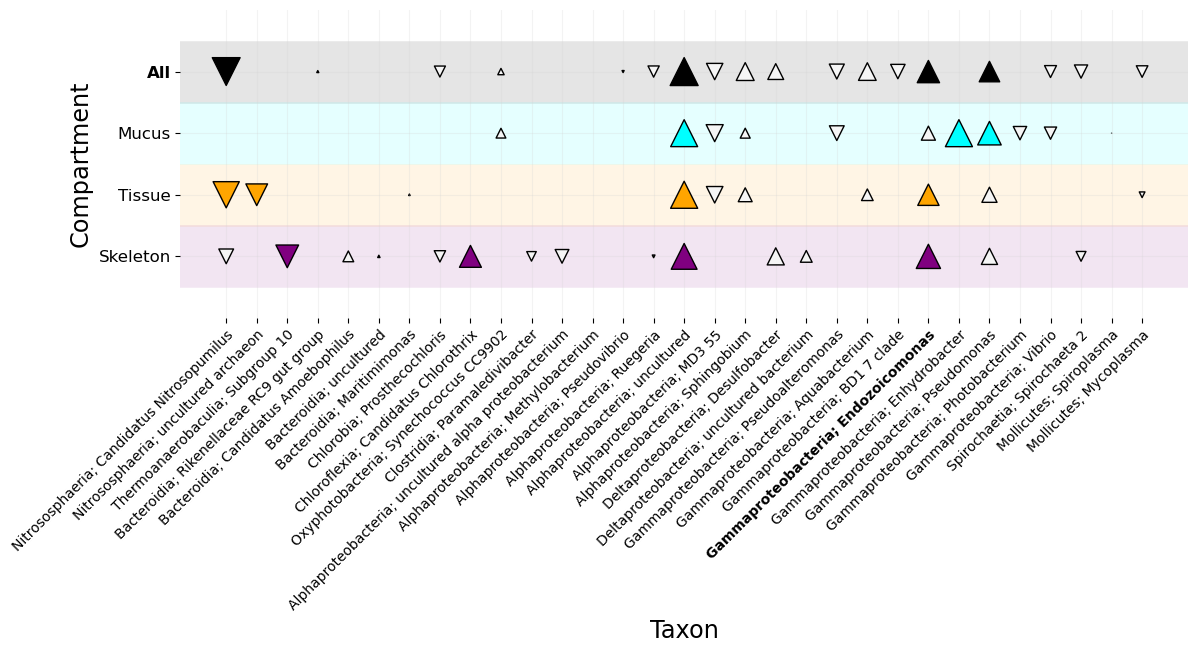

'../output/PIC_results/A12a_Taxa_vs_Growth_Rate_Zeros_Excluded/taxon_bubble_plot_A12a_Taxa_vs_Growth_Rate_Zeros_Excluded.png'

In [77]:

make_and_display_taxon_bubbleplot(\
  current_trait_table = "../output/trait_table_growth_rate_endos_present.tsv",
  current_trait = "growth_rate_mm_per_year",
  analysis_label = "A12a_Taxa_vs_Growth_Rate_Zeros_Excluded",
  output_dir = pic_dir)


## Analysis A12b Taxon Bubble Plot of Taxa vs. Growth Rate (zero counts included)

Running bubble plot command: python taxon_bubble_plot.py -i ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_and_growth_data_pcoa_zeros.tsv -t ../output/huang_roy_genus_tree.newick -o ../output/PIC_results -l A12b_Taxa_vs_Growth_Rate_Zeros_Included -c growth_rate_mm_per_year --verbose


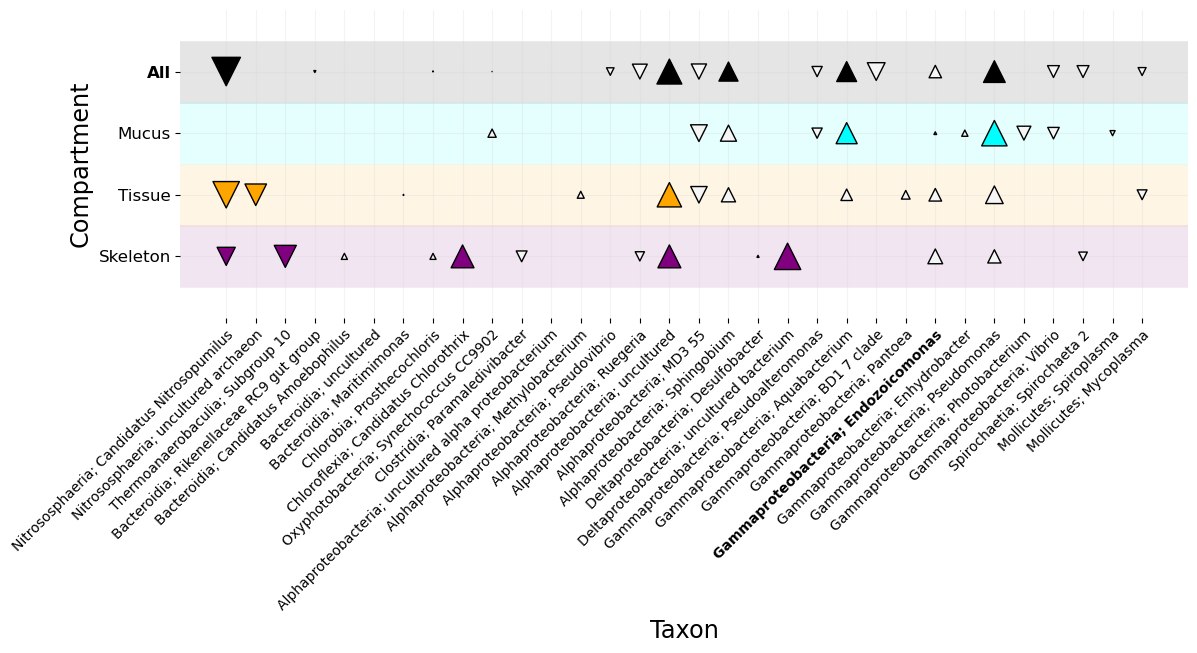

'../output/PIC_results/A12b_Taxa_vs_Growth_Rate_Zeros_Included/taxon_bubble_plot_A12b_Taxa_vs_Growth_Rate_Zeros_Included.png'

In [78]:
make_and_display_taxon_bubbleplot(\
  current_trait_table = trait_table_beta_diversity,
  current_trait = "growth_rate_mm_per_year",
  analysis_label = "A12b_Taxa_vs_Growth_Rate_Zeros_Included",
  output_dir = pic_dir)

## Analysis A13a Taxon Bubble Plot of Taxa vs. Disease (zero counts excluded)

Running bubble plot command: python taxon_bubble_plot.py -i ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata.tsv -t ../output/huang_roy_genus_tree.newick -o ../output/PIC_results -l A13a_Taxa_vs_Disease_Zeros_Excluded -c perc_dis --verbose


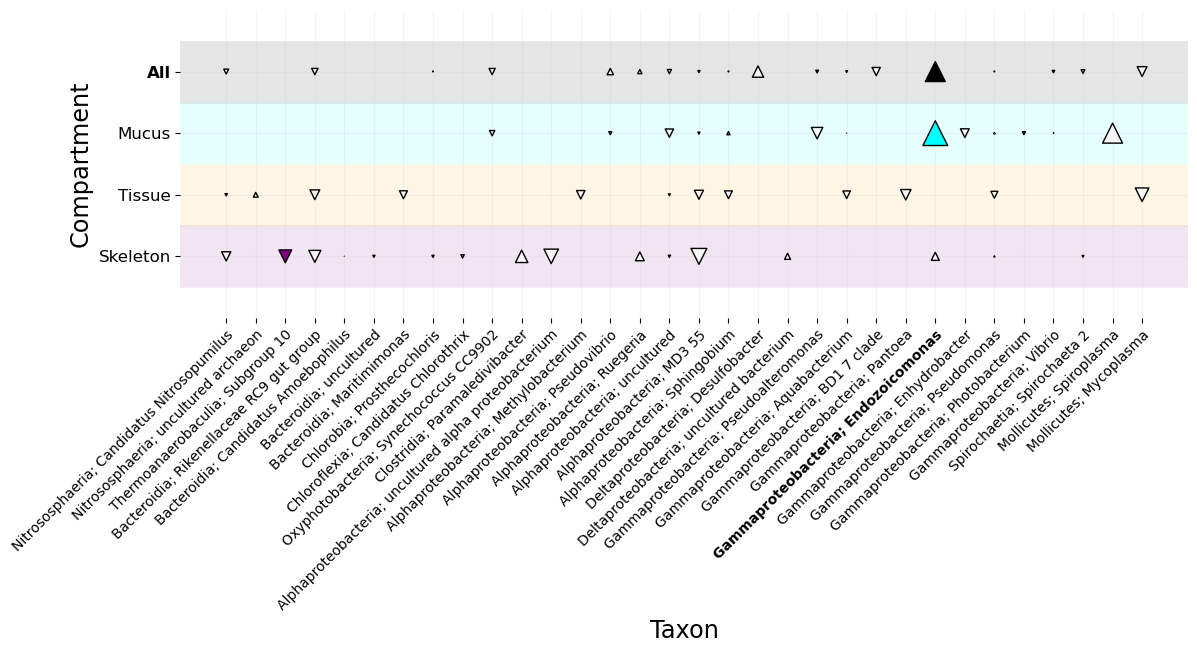

'../output/PIC_results/A13a_Taxa_vs_Disease_Zeros_Excluded/taxon_bubble_plot_A13a_Taxa_vs_Disease_Zeros_Excluded.png'

In [79]:
make_and_display_taxon_bubbleplot(\
  current_trait_table = trait_table_abundance_only,
  current_trait = "perc_dis",
  analysis_label = "A13a_Taxa_vs_Disease_Zeros_Excluded",
  output_dir = pic_dir)

## Analysis A13b Taxon Bubble Plot of Taxa vs. Disease (zero counts included)

Running bubble plot command: python taxon_bubble_plot.py -i ../output/GCMP_trait_table_with_abundances_and_adiv_and_metadata_zeros.tsv -t ../output/huang_roy_genus_tree.newick -o ../output/PIC_results -l A13b_Taxa_vs_Disease_Zeros_Included -c perc_dis --verbose


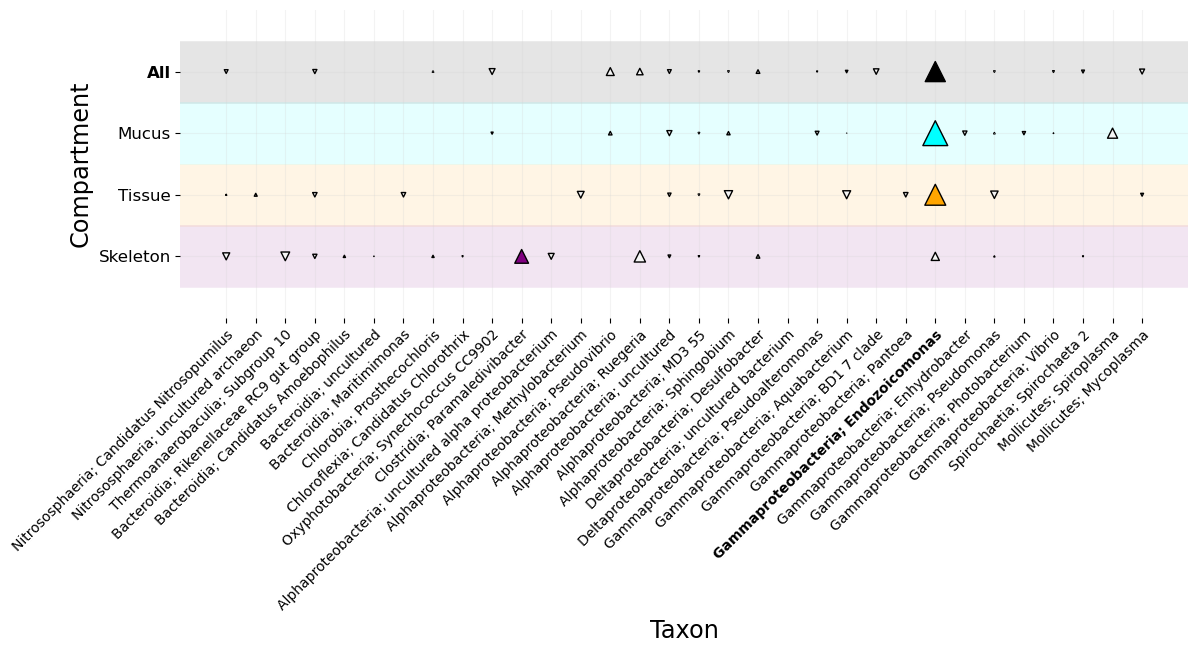

'../output/PIC_results/A13b_Taxa_vs_Disease_Zeros_Included/taxon_bubble_plot_A13b_Taxa_vs_Disease_Zeros_Included.png'

In [80]:
current_trait_table = trait_table
current_trait = "perc_dis"
analysis_label = "A13b_Taxa_vs_Disease_Zeros_Included"
pic_dir = join(results_dir,"PIC_results")

make_and_display_taxon_bubbleplot(\
  current_trait_table = trait_table,
  current_trait = "perc_dis",
  analysis_label = "A13b_Taxa_vs_Disease_Zeros_Included",
  output_dir = pic_dir)